<cell_type>markdown</cell_type># 04 - Phenotype Associations Analysis

## AF Phenotype Discovery from ILR Data

### Objective

Comprehensive analysis of AF phenotype associations with:

**Baseline Characteristics:**
- Demographics & Anthropometrics (age, sex, BMI, BSA, waist circumference, body fat)
- AF History (type, mEHRA symptom score, prior ablation/cardioversion)
- Comorbidities (HTN, DM, HF, stroke/TIA, vascular disease, COPD, OSA)
- Risk Scores (CHA₂DS₂-VASc)
- Medications (beta-blockers, anticoagulation, antiarrhythmics, etc.)
- Laboratory Values (lipids, renal function, glucose, hs-CRP, NT-proBNP, TnT)
- Lifestyle (smoking, alcohol, exercise)

**Imaging & Function:**
- Echocardiography: LV function, LA size/strain, RV function, diastolic function
- BSA-indexed values: LVEDV/BSA, LVESV/BSA, LA area/BSA, SV index, Cardiac Index
- VO₂peak-indexed values (per Letnes et al. 2023): LVEDV/VO₂peak, LA area/VO₂peak
- Cardiopulmonary exercise test (CPET): VO₂peak, HR max, RER, workload, HR recovery

**Trial & Exercise:**
- NEXAF trial arm distribution
- Exercise time changes

**Clinical Outcomes:**
- Hospitalization rates
- Quality of Life (AFEQT, SF-12, EQ-VAS) trajectory
- Post-intervention procedures
- Medication changes (baseline → post)

**Statistical Methods:**
- Kruskal-Wallis H-test for continuous variables
- Chi-square test for categorical variables
- All tables include sample size (N) and p-values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from src.preprocessing import AFDataLoader
from src.analysis import (
    generate_phenotype_names,
    get_phenotype_display_cols,
    create_analysis_table,
    calculate_bsa,
    format_pvalue,
    DEFAULT_PHENOTYPE_COLORS,
)

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
%matplotlib inline

# Phenotype colors (imported from src.analysis)
PHENOTYPE_COLORS = DEFAULT_PHENOTYPE_COLORS

In [2]:
# Reload analysis module to pick up any code changes
import importlib
import src.analysis.phenotype_analysis
importlib.reload(src.analysis.phenotype_analysis)
from src.analysis.phenotype_analysis import create_analysis_table

---
## 1.5 Curated Clustering Features Reference

The phenotype clustering uses **14 curated features** selected from ~110 candidate features 
(see `02_feature_engineering.ipynb` for the full selection process).

These features were chosen based on:
- **Clinical interpretability**: Directly meaningful to clinicians
- **Discriminative power**: Ability to separate phenotypes (RF importance + ANOVA F-score)
- **Non-redundancy**: Avoiding highly correlated features (r > 0.8)

In [3]:
# Curated features for phenotype clustering with descriptions
CURATED_FEATURES = {
    # BURDEN - Primary AF outcome measures
    'total_af_hours': 'Total hours in AF over follow-up period',
    'af_burden_percent': 'Percentage of time in AF (burden / total time)',
    
    # EPISODE COUNT & PATTERN - Episode characteristics
    'n_episodes': 'Total number of AF episodes',
    'mean_episode_duration': 'Average episode duration (minutes)',
    'max_episode_duration': 'Longest episode duration (minutes)',
    'cv_episode_duration': 'Coefficient of variation of episode duration (variability)',
    'burstiness_index': 'Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)',
    
    # TEMPORAL PATTERN - When AF occurs
    'pct_daytime_episodes': 'Percentage of episodes starting during daytime (6am-10pm)',
    'hourly_entropy': 'Spread of episodes across hours (higher=more evenly distributed)',
    
    # HEART RATE / RATE CONTROL - Ventricular response
    'mean_ventricular_rate': 'Average heart rate during AF episodes (bpm)',
    'pct_rapid_af': 'Percentage of episodes with rapid ventricular response (>110 bpm)',
    'pct_controlled_af': 'Percentage of episodes with controlled rate (60-110 bpm)',
    
    # TRAJECTORY / PROGRESSION - How AF evolves over time
    'trajectory_slope': 'Rate of AF burden accumulation over time (minutes/day)',
    'longest_plateau_episodes': 'Longest period with minimal AF activity (stability indicator)',
}

# Feature category mapping
FEATURE_CATEGORIES = {
    'total_af_hours': 'Burden',
    'af_burden_percent': 'Burden',
    'n_episodes': 'Episode',
    'mean_episode_duration': 'Episode',
    'max_episode_duration': 'Episode',
    'cv_episode_duration': 'Episode',
    'burstiness_index': 'Episode',
    'pct_daytime_episodes': 'Temporal',
    'hourly_entropy': 'Temporal',
    'mean_ventricular_rate': 'Rate Control',
    'pct_rapid_af': 'Rate Control',
    'pct_controlled_af': 'Rate Control',
    'trajectory_slope': 'Trajectory',
    'longest_plateau_episodes': 'Trajectory',
}

# Category colors for visualization
CATEGORY_COLORS = {
    'Burden': '#e41a1c',
    'Episode': '#377eb8',
    'Temporal': '#4daf4a',
    'Rate Control': '#984ea3',
    'Trajectory': '#ff7f00',
}

print(f"Defined {len(CURATED_FEATURES)} curated features for phenotype clustering")

Defined 14 curated features for phenotype clustering


In [4]:
# Load features and display curated feature summary by phenotype with p-values and importance
_features_df = pd.read_csv('../output/features_with_phenotypes_4k.csv')
_n_phenotypes = _features_df['phenotype'].nunique()

# Calculate feature importance using ANOVA F-scores
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

# Prepare data for importance calculation
curated_cols = [f for f in CURATED_FEATURES.keys() if f in _features_df.columns]
X_curated = _features_df[curated_cols].fillna(_features_df[curated_cols].median())
X_scaled = StandardScaler().fit_transform(X_curated)
y = _features_df['phenotype'].values

f_scores, f_pvals = f_classif(X_scaled, y)
importance_dict = dict(zip(curated_cols, f_scores))
importance_max = max(f_scores) if max(f_scores) > 0 else 1

# Build feature summary table with p-values and importance
feature_rows = []
for feat, desc in CURATED_FEATURES.items():
    if feat in _features_df.columns:
        row = {
            'Feature': feat,
            'Description': desc,
            'Category': FEATURE_CATEGORIES.get(feat, 'Other'),
        }
        # Add mean per phenotype
        groups = []
        for p in range(_n_phenotypes):
            subset = _features_df[_features_df['phenotype'] == p][feat].dropna()
            row[f'P{p}'] = f"{subset.mean():.1f}"
            groups.append(subset.values)
        
        # Kruskal-Wallis p-value
        try:
            stat, pval = stats.kruskal(*groups)
            row['p-value'] = pval
        except:
            row['p-value'] = np.nan
        
        # Feature importance (normalized F-score)
        row['Importance'] = importance_dict.get(feat, 0) / importance_max
        
        feature_rows.append(row)

ilr_features_df = pd.DataFrame(feature_rows)

# Sort by importance
ilr_features_df = ilr_features_df.sort_values('Importance', ascending=False)

# Format for display
print("=" * 100)
print("ILR MONITORING FEATURES - Mean Values by Phenotype with Statistical Tests")
print("=" * 100)
print()

# Display with category grouping
for category in ['Burden', 'Episode', 'Temporal', 'Rate Control', 'Trajectory']:
    cat_df = ilr_features_df[ilr_features_df['Category'] == category].copy()
    if len(cat_df) > 0:
        print(f"\n{category.upper()}")
        print("-" * 80)
        for _, row in cat_df.iterrows():
            feat_name = row['Feature']
            desc = row['Description']
            means = ' | '.join([f"P{p}: {row[f'P{p}']}" for p in range(_n_phenotypes)])
            pval_str = f"p={row['p-value']:.4f}" if pd.notna(row['p-value']) else "p=N/A"
            imp_str = f"Imp={row['Importance']:.2f}"
            print(f"  {feat_name} ({pval_str}, {imp_str})")
            print(f"    {desc}")
            print(f"    {means}")

# Display as formatted table
print("\n")
display_cols = ['Feature', 'Category'] + [f'P{p}' for p in range(_n_phenotypes)] + ['p-value', 'Importance']
display_df = ilr_features_df[display_cols].copy()
display_df['p-value'] = display_df['p-value'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
display_df['Importance'] = display_df['Importance'].apply(lambda x: f"{x:.2f}")
display(display_df)

ILR MONITORING FEATURES - Mean Values by Phenotype with Statistical Tests


BURDEN
--------------------------------------------------------------------------------
  af_burden_percent (p=0.0000, Imp=1.00)
    Percentage of time in AF (burden / total time)
    P0: 47.4 | P1: 2.2 | P2: 6.7 | P3: 0.8
  total_af_hours (p=0.0000, Imp=0.81)
    Total hours in AF over follow-up period
    P0: 3684.6 | P1: 149.9 | P2: 530.6 | P3: 35.5

EPISODE
--------------------------------------------------------------------------------
  max_episode_duration (p=0.0000, Imp=0.30)
    Longest episode duration (minutes)
    P0: 47914.3 | P1: 1199.7 | P2: 2817.3 | P3: 1430.2
  burstiness_index (p=0.0000, Imp=0.20)
    Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)
    P0: 0.4 | P1: 0.2 | P2: 0.4 | P3: -0.2
  cv_episode_duration (p=0.0000, Imp=0.09)
    Coefficient of variation of episode duration (variability)
    P0: 4.4 | P1: 1.3 | P2: 2.2 | P3: 0.5
  n_episodes (p=0.0000, Imp=0.07)
    To

,Feature,Category,P0,P1,P2,P3,p-value,Importance
1,af_burden_percent,Burden,47.4,2.2,6.7,0.8,0.0000,1.00
10,pct_rapid_af,Rate Control,15.9,83.2,17.6,11.1,0.0000,0.99
11,pct_controlled_af,Rate Control,72.7,16.7,75.9,87.3,0.0000,0.89
0,total_af_hours,Burden,3684.6,149.9,530.6,35.5,0.0000,0.81
9,mean_ventricular_rate,Rate Control,85.2,128.6,86.9,88.2,0.0000,0.57
8,hourly_entropy,Temporal,3.8,2.8,4.1,1.6,0.0000,0.32
4,max_episode_duration,Episode,47914.3,1199.7,2817.3,1430.2,0.0000,0.30
13,longest_plateau_episodes,Trajectory,3.6,2.0,4.5,0.6,0.0000,0.22
6,burstiness_index,Episode,0.4,0.2,0.4,-0.2,0.0000,0.20
12,trajectory_slope,Trajectory,798.2,62.5,120.9,75.7,0.0000,0.17


---
## 1. Load Data

In [5]:
# Load phenotype assignments
features_df = pd.read_csv('../output/features_with_phenotypes_4k.csv')

# Detect number of phenotypes dynamically
N_PHENOTYPES = features_df['phenotype'].nunique()
PHENOTYPE_NAMES = generate_phenotype_names(features_df, N_PHENOTYPES)

print(f"Phenotype data: {features_df.shape}")
print(f"  Patients: {len(features_df)}")
print(f"  Phenotypes detected: {N_PHENOTYPES}")
print(f"\nPhenotype names:")
for p, name in PHENOTYPE_NAMES.items():
    print(f"  {name}")

Phenotype data: (246, 16)
  Patients: 246
  Phenotypes detected: 4

Phenotype names:
  P0: 47.4% burden - 1140 episodes - 6573 min
  P1: 2.2% burden - 133 episodes - 175 min
  P2: 6.7% burden - 458 episodes - 230 min
  P3: 0.8% burden - 6 episodes - 706 min


In [6]:
# Load baseline and burden data
loader = AFDataLoader()
df_baseline = loader.load_baseline()
df_burden = loader.load_burden()

# Fix ID types for merging
features_df['ID'] = features_df['ID'].astype(int).astype(str)
df_baseline['ID'] = df_baseline['ID'].astype(str)
df_burden['ID'] = df_burden['ID'].astype(int).astype(str)

# Create properly coded binary variables for display (see database/VARIABLES.md for codings)
# Sex: Kjønn is 1=Male, 2=Female -> create Male binary (1=Male, 0=Female)
if 'Kjønn' in df_baseline.columns:
    df_baseline['Male'] = (df_baseline['Kjønn'] == 1).astype(int)

# AF Type: BL_AF_type is 1=Paroxysmal, 2=Persistent -> create Paroxysmal binary (1=Paroxysmal, 0=Persistent)
if 'BL_AF_type' in df_baseline.columns:
    df_baseline['Paroxysmal_AF'] = (df_baseline['BL_AF_type'] == 1).astype(int)

# Rand_arm: 1=Training, 2=Control -> create Training binary
if 'Rand_arm' in df_burden.columns:
    df_burden['Training_arm'] = (df_burden['Rand_arm'] == 1).astype(int)

print(f"Baseline data: {df_baseline.shape}")
print(f"Burden/outcome data: {df_burden.shape}")

Baseline data: (295, 716)
Burden/outcome data: (294, 1156)


<cell_type>markdown</cell_type>---
## 2. Baseline Characteristics

Comprehensive analysis of demographics, anthropometrics, AF history, comorbidities, medications, laboratory values, lifestyle, and risk scores.

In [7]:
# Comprehensive baseline variables organized by domain
baseline_vars = {
    # Demographics
    'Alder': 'Age (years)',
    'Male': 'Male Sex',  # Recoded from Kjønn (1=Male, 2=Female)
    
    # Anthropometrics
    'BL_høyde': 'Height (cm)',
    'BL_vekt': 'Weight (kg)',
    'BL_BMI': 'BMI (kg/m²)',
    'BL_midjemål': 'Waist Circumference (cm)',
    'BL_fettprosent': 'Body Fat (%)',
    
    # AF History
    'Paroxysmal_AF': 'Paroxysmal AF',  # Recoded from BL_AF_type (1=Paroxysmal, 2=Persistent)
    'BL_mEHRA': 'mEHRA Score',
    'BL_ablasjon_nei_ja': 'Prior Ablation',
    'BL_ablasjon_antall': 'Number of Prior Ablations',
    'BL_konvertering_nei_ja': 'Prior Cardioversion',
    'BL_konvertering_antall': 'Number of Prior Cardioversions',
    
    # Comorbidities
    'BL_HTN': 'Hypertension',
    'BL_DM2': 'Diabetes Type 2',
    'BL_DM1': 'Diabetes Type 1',
    'BL_komb.DM': 'Diabetes (any)',
    'BL_NSTEMI': 'Prior NSTEMI',
    'BL_STEMI': 'Prior STEMI',
    'BL_angina': 'Angina Pectoris',
    'BL_CABG': 'Prior CABG',
    'BL_HFrEF': 'HFrEF',
    'BL_HFpEF': 'HFpEF',
    'BL_komb.HF': 'Heart Failure (any)',
    'BL_hjerneinfarkt': 'Prior Stroke',
    'BL_TIA': 'Prior TIA',
    'BL_komb.TIAinfarkt': 'Cerebrovascular Event (any)',
    'BL_karsykdom': 'Vascular Disease',
    'BL_komb.karsykdom': 'Vascular Disease (combined)',
    'BL_COPD': 'COPD',
    'BL_OSA': 'Sleep Apnea (OSA)',
    
    # Risk Scores
    'CHA2DS2VA': 'CHA₂DS₂-VASc Score',
    
    # Medications
    'BL_betabl': 'Beta-blocker (baseline)',
    'BL_betablokker_idag': 'Beta-blocker (day of test)',
    'BL_antikoag': 'Anticoagulation',
    'BL_antiarrytm': 'Antiarrhythmic',
    'BL_platehemmende': 'Antiplatelet',
    'BL_blodtrykkssenkende': 'Antihypertensive',
    'BL_kolesterolsenkende': 'Lipid-lowering',
    'BL_kalsiumantagonist': 'Calcium Channel Blocker',
    
    # Laboratory Values
    'BL_kolesterol_total': 'Total Cholesterol (mmol/L)',
    'BL_HDL': 'HDL Cholesterol (mmol/L)',
    'BL_LDL': 'LDL Cholesterol (mmol/L)',
    'BL_triglyserider': 'Triglycerides (mmol/L)',
    'BL_kreatinin': 'Creatinine (μmol/L)',
    'BL_eGFR': 'eGFR (mL/min/1.73m²)',
    'BL_glukose': 'Fasting Glucose (mmol/L)',
    'BL_hsCRP_pre': 'hs-CRP (mg/L)',
    'BL_NTproBNP_pre': 'NT-proBNP (pg/mL)',
    'BL_TnT_pre': 'Troponin T (ng/L)',
    
    # Lifestyle
    'BL_Smoking_status': 'Current Smoker',
    'BL_AlcFLY': 'Alcohol Frequency',
    'BL_ExeMin': 'Exercise (min/week)',
}

# Merge phenotypes with baseline
available_vars = {k: v for k, v in baseline_vars.items() if k in df_baseline.columns}
baseline_cols = ['ID'] + list(available_vars.keys())
df = features_df[['ID', 'phenotype']].merge(
    df_baseline[baseline_cols], on='ID', how='left'
)

# Calculate BSA for later indexed calculations
if 'BL_høyde' in df.columns and 'BL_vekt' in df.columns:
    df['BSA'] = calculate_bsa(df['BL_høyde'], df['BL_vekt'])
    available_vars['BSA'] = 'BSA (m²)'

print(f"Merged dataset: {df.shape}")
print(f"Available baseline variables: {len(available_vars)}")

Merged dataset: (246, 55)
Available baseline variables: 53


In [8]:
# Create comprehensive baseline characteristics tables by domain

# Define count variables that should be treated as continuous
count_vars = ['BL_ablasjon_antall', 'BL_konvertering_antall', 'CHA2DS2VA', 'BL_mEHRA']

# --- Demographics & Anthropometrics ---
demo_vars = {k: v for k, v in available_vars.items() if k in [
    'Alder', 'Male', 'BL_høyde', 'BL_vekt', 'BL_BMI', 'BL_midjemål', 'BL_fettprosent', 'BSA'
]}
demo_table = create_analysis_table(df, demo_vars, n_phenotypes=N_PHENOTYPES)
demo_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("DEMOGRAPHICS & ANTHROPOMETRICS")
print("=" * 100)
display(demo_table.sort_values('p-value')[demo_display])

# --- AF History ---
af_vars = {k: v for k, v in available_vars.items() if k in [
    'Paroxysmal_AF', 'BL_mEHRA', 'BL_ablasjon_nei_ja', 'BL_ablasjon_antall',
    'BL_konvertering_nei_ja', 'BL_konvertering_antall'
]}
af_table = create_analysis_table(df, af_vars, n_phenotypes=N_PHENOTYPES, force_continuous=count_vars)

print("\nAF HISTORY")
print("=" * 100)
display(af_table.sort_values('p-value')[demo_display])

# --- Comorbidities ---
comorb_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_HTN', 'BL_DM2', 'BL_DM1', 'BL_komb.DM', 'BL_NSTEMI', 'BL_STEMI', 
    'BL_angina', 'BL_CABG', 'BL_HFrEF', 'BL_HFpEF', 'BL_komb.HF',
    'BL_hjerneinfarkt', 'BL_TIA', 'BL_komb.TIAinfarkt', 'BL_karsykdom',
    'BL_komb.karsykdom', 'BL_COPD', 'BL_OSA', 'CHA2DS2VA'
]}
comorb_table = create_analysis_table(df, comorb_vars, n_phenotypes=N_PHENOTYPES, force_continuous=count_vars)

print("\nCOMORBIDITIES & RISK SCORES")
print("=" * 100)
display(comorb_table.sort_values('p-value')[demo_display])

# --- Medications ---
med_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_betabl', 'BL_betablokker_idag', 'BL_antikoag', 'BL_antiarrytm',
    'BL_platehemmende', 'BL_blodtrykkssenkende', 'BL_kolesterolsenkende', 'BL_kalsiumantagonist'
]}
med_table = create_analysis_table(df, med_vars, n_phenotypes=N_PHENOTYPES)

print("\nMEDICATIONS")
print("=" * 100)
display(med_table.sort_values('p-value')[demo_display])

# --- Laboratory Values ---
lab_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_kolesterol_total', 'BL_HDL', 'BL_LDL', 'BL_triglyserider',
    'BL_kreatinin', 'BL_eGFR', 'BL_glukose', 'BL_hsCRP_pre', 'BL_NTproBNP_pre', 'BL_TnT_pre'
]}
lab_table = create_analysis_table(df, lab_vars, n_phenotypes=N_PHENOTYPES)

print("\nLABORATORY VALUES")
print("=" * 100)
display(lab_table.sort_values('p-value')[demo_display])

# --- Lifestyle ---
life_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_Smoking_status', 'BL_AlcFLY', 'BL_ExeMin'
]}
life_table = create_analysis_table(df, life_vars, n_phenotypes=N_PHENOTYPES)

print("\nLIFESTYLE")
print("=" * 100)
display(life_table.sort_values('p-value')[demo_display])

# Combine all tables for export
all_baseline = pd.concat([
    demo_table.assign(Category='Demographics'),
    af_table.assign(Category='AF History'),
    comorb_table.assign(Category='Comorbidities'),
    med_table.assign(Category='Medications'),
    lab_table.assign(Category='Laboratory'),
    life_table.assign(Category='Lifestyle')
], ignore_index=True)

print(f"\n\nTotal baseline variables analyzed: {len(all_baseline)}")
print(f"Significant associations (p<0.05): {(all_baseline['p-value'] < 0.05).sum()}")

DEMOGRAPHICS & ANTHROPOMETRICS


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Age (years),246,64.3 (10.4),67.8 (9.1),61.2 (10.3),65.6 (9.7),64.8 (11.3),0.005442
2,Height (cm),246,177.2 (9.4),174.6 (7.8),178.2 (9.6),177.2 (8.8),176.7 (10.5),0.359202
6,Body Fat (%),159,30.6 (8.8),33.5 (7.5),30.1 (8.0),30.3 (9.1),30.5 (9.8),0.457859
4,BMI (kg/m²),246,27.6 (4.8),28.5 (4.9),27.6 (5.1),27.7 (4.6),27.2 (4.9),0.619686
5,Waist Circumference (cm),241,99.5 (13.5),102.6 (15.1),98.6 (14.7),100.0 (12.4),98.9 (12.9),0.642987
1,Male Sex,246,68.7%,63.6%,69.7%,71.6%,65.0%,0.795367
3,Weight (kg),246,86.8 (17.0),87.0 (17.2),87.9 (18.8),87.1 (16.3),84.8 (15.8),0.883738
7,BSA (m²),246,2.0 (0.2),2.0 (0.2),2.1 (0.2),2.0 (0.2),2.0 (0.2),0.914040



AF HISTORY


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Paroxysmal AF,246,73.2%,40.9%,78.9%,71.6%,80.0%,0.002305
1,mEHRA Score,246,3,2b,2b,3,3,0.134497
4,Prior Cardioversion,246,41.5%,59.1%,36.8%,42.0%,40.0%,0.314276
3,Number of Prior Ablations,47,1.5 (0.8),2.0 (1.2),1.5 (1.0),1.6 (0.8),1.2 (0.4),0.326558
2,Prior Ablation,246,19.5%,18.2%,15.8%,23.9%,18.3%,0.612862
5,Number of Prior Cardioversions,101,3.1 (3.7),3.3 (4.0),3.6 (4.5),3.2 (3.7),2.2 (2.1),0.703580



COMORBIDITIES & RISK SCORES


,Variable,N,Overall,P0,P1,P2,P3,p-value
18,CHA₂DS₂-VASc Score,246,1.5 (1.4),2.0 (1.4),1.2 (1.2),1.6 (1.4),1.7 (1.5),0.025452
1,Diabetes Type 2,246,5.3%,0.0%,7.9%,1.1%,10.0%,0.046999
3,Diabetes (any),246,6.1%,4.5%,9.2%,1.1%,10.0%,0.080040
2,Diabetes Type 1,244,0.8%,4.5%,1.3%,0.0%,0.0%,0.158179
4,Prior NSTEMI,245,1.2%,4.5%,0.0%,2.3%,0.0%,0.214163
5,Prior STEMI,246,2.4%,4.5%,1.3%,4.5%,0.0%,0.266464
15,Vascular Disease (combined),246,14.2%,9.1%,9.2%,15.9%,20.0%,0.274105
13,Cerebrovascular Event (any),246,4.9%,9.1%,2.6%,3.4%,8.3%,0.305390
12,Prior TIA,245,3.3%,4.5%,1.3%,2.3%,6.8%,0.306771
0,Hypertension,246,42.3%,54.5%,36.8%,46.6%,38.3%,0.343450



MEDICATIONS


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,Anticoagulation,246,67.1%,86.4%,52.6%,70.5%,73.3%,0.006119
7,Calcium Channel Blocker,246,17.1%,22.7%,10.5%,26.1%,10.0%,0.018370
6,Lipid-lowering,244,34.8%,36.4%,22.4%,46.0%,33.9%,0.018511
5,Antihypertensive,245,43.7%,68.2%,34.2%,48.9%,39.0%,0.021992
1,Beta-blocker (day of test),241,27.8%,38.1%,18.7%,29.1%,33.9%,0.145486
0,Beta-blocker (baseline),244,36.1%,45.5%,28.9%,36.4%,41.4%,0.358257
3,Antiarrhythmic,245,13.9%,13.6%,9.2%,15.9%,16.9%,0.540717
4,Antiplatelet,238,2.9%,0.0%,3.9%,2.4%,3.6%,0.780249



LABORATORY VALUES


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,LDL Cholesterol (mmol/L),243,3.1 (1.0),2.7 (0.9),3.4 (1.0),3.0 (1.0),2.9 (1.0),0.001737
9,Troponin T (ng/L),155,9.3 (4.6),11.1 (5.0),7.7 (3.7),9.9 (4.3),10.0 (5.4),0.011067
8,NT-proBNP (pg/mL),152,160.5 (182.8),223.9 (195.3),109.9 (119.9),191.3 (236.3),157.7 (131.7),0.023548
0,Total Cholesterol (mmol/L),242,4.8 (1.0),4.5 (0.9),5.1 (1.1),4.7 (1.0),4.6 (1.0),0.025465
5,eGFR (mL/min/1.73m²),243,82.5 (12.3),75.1 (16.8),84.4 (11.1),81.1 (11.9),84.7 (11.7),0.047165
7,hs-CRP (mg/L),235,2.5 (3.6),2.4 (1.6),2.8 (2.6),2.3 (4.9),2.6 (2.6),0.068403
1,HDL Cholesterol (mmol/L),243,1.4 (0.5),1.6 (0.5),1.4 (0.4),1.5 (0.6),1.4 (0.4),0.258313
3,Triglycerides (mmol/L),242,1.2 (0.6),1.0 (0.3),1.3 (0.6),1.2 (0.6),1.2 (0.8),0.313410
4,Creatinine (μmol/L),244,76.5 (14.5),81.2 (20.8),75.0 (12.5),78.0 (15.2),74.7 (13.2),0.515544
6,Fasting Glucose (mmol/L),243,5.9 (4.1),5.6 (0.5),6.4 (7.2),5.6 (0.7),5.6 (1.0),0.733337



LIFESTYLE


,Variable,N,Overall,P0,P1,P2,P3,p-value
1,Alcohol Frequency,246,3,3,3,4,3,0.480765
0,Current Smoker,240,2.0,2.0,2.0,2.0,2.0,0.937461




Total baseline variables analyzed: 53
Significant associations (p<0.05): 13


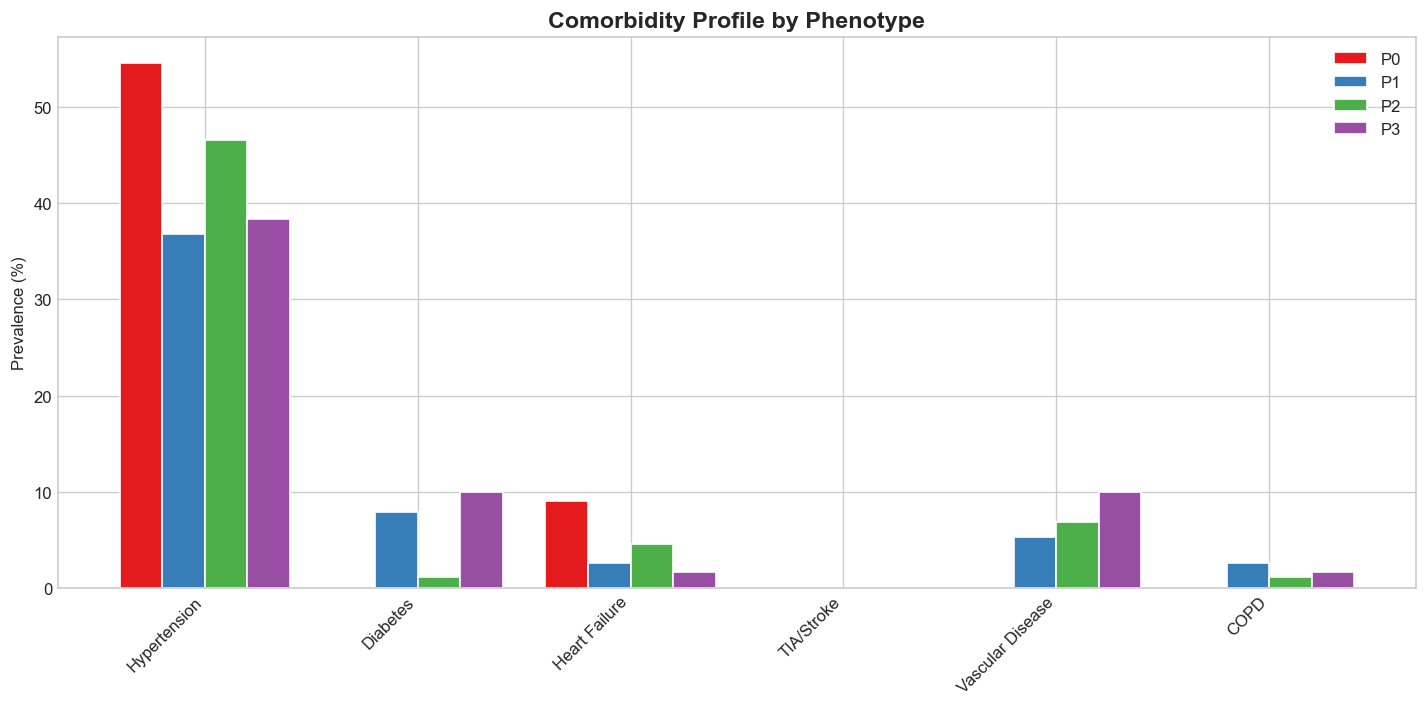

In [9]:
# Visualize comorbidities
comorbidity_vars = ['BL_HTN', 'BL_DM2', 'BL_komb.HF', 'BL_komb.TIAinfarkt', 'BL_karsykdom', 'BL_COPD']
comorbidity_labels = ['Hypertension', 'Diabetes', 'Heart Failure', 'TIA/Stroke', 'Vascular Disease', 'COPD']
available_comorb = [(v, l) for v, l in zip(comorbidity_vars, comorbidity_labels) if v in df.columns]

if len(available_comorb) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(available_comorb))
    width = 0.8 / N_PHENOTYPES
    
    for p in range(N_PHENOTYPES):
        rates = []
        for col, label in available_comorb:
            vals = df[df['phenotype'] == p][col].dropna()
            rate = 100 * (vals == 1).sum() / len(vals) if len(vals) > 0 else 0
            rates.append(rate)
        offset = (p - (N_PHENOTYPES - 1) / 2) * width
        ax.bar(x + offset, rates, width, label=f'P{p}', color=PHENOTYPE_COLORS[p])
    
    ax.set_xticks(x)
    ax.set_xticklabels([l for v, l in available_comorb], rotation=45, ha='right')
    ax.set_ylabel('Prevalence (%)')
    ax.set_title('Comorbidity Profile by Phenotype', fontsize=14, fontweight='bold')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../output/figures/baseline_comorbidities.png', dpi=150, bbox_inches='tight')
    plt.show()

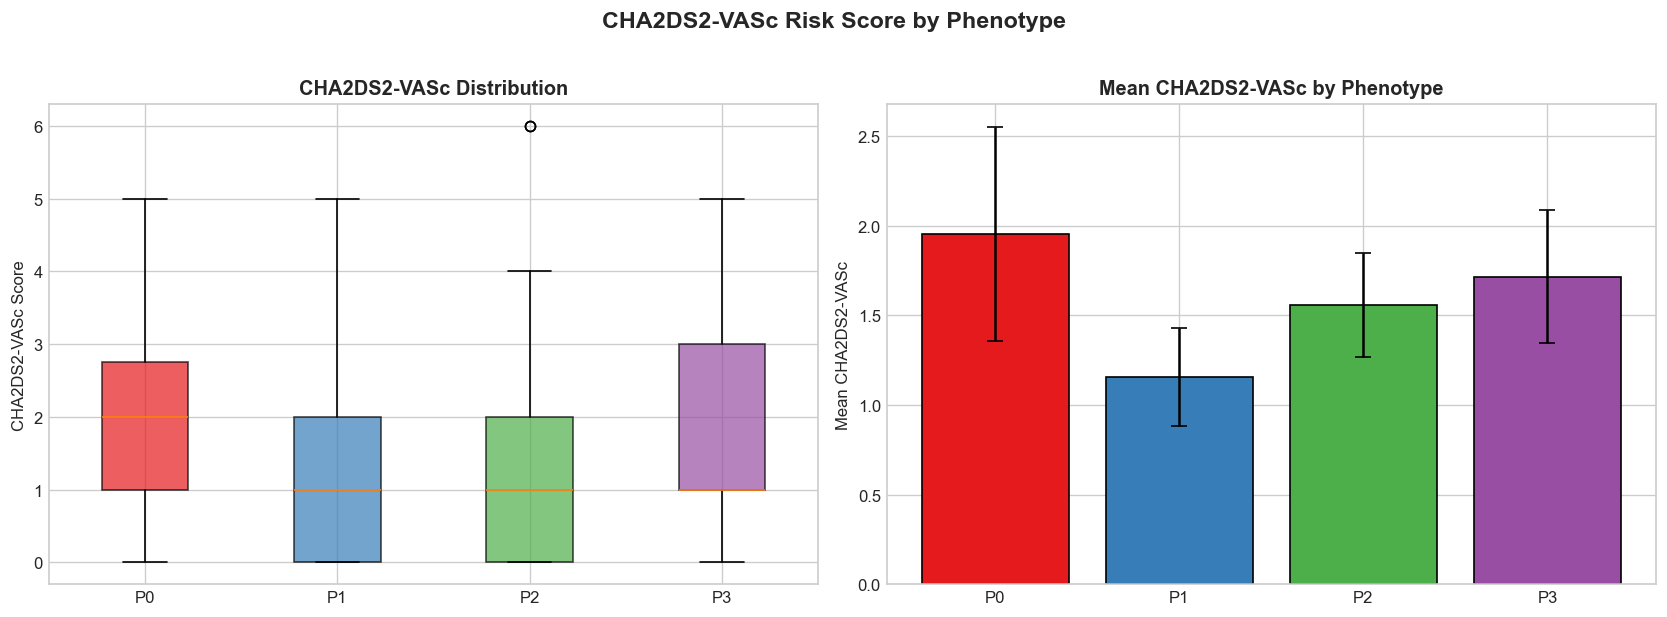

In [10]:
# CHA2DS2-VASc by phenotype
if 'CHA2DS2VA' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    box_data = [df[df['phenotype'] == p]['CHA2DS2VA'].dropna() for p in range(N_PHENOTYPES)]
    bp = axes[0].boxplot(box_data, patch_artist=True, positions=range(N_PHENOTYPES))
    
    for patch, color in zip(bp['boxes'], PHENOTYPE_COLORS[:N_PHENOTYPES]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0].set_xticks(range(N_PHENOTYPES))
    axes[0].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[0].set_ylabel('CHA2DS2-VASc Score')
    axes[0].set_title('CHA2DS2-VASc Distribution', fontweight='bold')
    
    means = [df[df['phenotype'] == p]['CHA2DS2VA'].mean() for p in range(N_PHENOTYPES)]
    cis = [1.96 * df[df['phenotype'] == p]['CHA2DS2VA'].std() / 
           np.sqrt(len(df[df['phenotype'] == p])) for p in range(N_PHENOTYPES)]
    
    axes[1].bar(range(N_PHENOTYPES), means, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[1].errorbar(range(N_PHENOTYPES), means, yerr=cis, fmt='none', color='black', capsize=5)
    axes[1].set_xticks(range(N_PHENOTYPES))
    axes[1].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[1].set_ylabel('Mean CHA2DS2-VASc')
    axes[1].set_title('Mean CHA2DS2-VASc by Phenotype', fontweight='bold')
    
    plt.suptitle('CHA2DS2-VASc Risk Score by Phenotype', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../output/figures/baseline_cha2ds2vasc.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 3. Echocardiography

Comprehensive echo analysis organized into:

### 3.1 Baseline Echocardiography
Raw echo parameters including LV function, LA assessment, RV function, and diastolic function.

### 3.2 Post-intervention Echocardiography  
Post-intervention echo parameters for comparison with baseline.


In [11]:
# Baseline echo variables (raw values only)
echo_vars = {
    # LV Function
    'BL_lvef_bip_ai': 'LV EF Biplane (%)',
    'BL_ef_biplane_03_percent': 'LV EF Biplane Alt (%)',
    'BL_lvedv_bip_ai': 'LV EDV (ml)',
    'BL_lvesv_bip_ai': 'LV ESV (ml)',
    'BL_lvot_sv_ml': 'Stroke Volume (ml)',
    'BL_lvot_co_l_min': 'Cardiac Output (L/min)',
    
    # LA Assessment
    'BL_la_cm': 'LA Diameter (cm)',
    'BL_la_as_a4c_cm2': 'LA Area 4C (cm²)',
    'BL_laesv_bip_ai': 'LA ESV Biplane (ml)',
    'BL_laesv_mod_bp_ml': 'LA ESV Modified BP (ml)',
    'BL_auto_laq_vmax_ml': 'LA Volume Max (ml)',
    'BL_auto_laq_vmin_ml': 'LA Volume Min (ml)',
    'BL_auto_laq_gls_r_percent': 'LA Reservoir Strain (%)',
    'BL_auto_laq_gls_cd_percent': 'LA Conduit Strain (%)',
    'BL_auto_laq_gls_ct_percent': 'LA Contractile Strain (%)',
    
    # RV Function
    'BL_mm_tapse_cm': 'TAPSE (cm)',
    'BL_rv_sprime_velocity_m_s': "RV S' Velocity (m/s)",
    
    # Diastolic Function
    'BL_mv_e_velocity_m_s': 'Mitral E Velocity (m/s)',
    'BL_mv_a_velocity_m_s': 'Mitral A Velocity (m/s)',
    'BL_mv_e_a_ratio_1': 'E/A Ratio',
    'BL_mv_e_eprime_average_ratio_calc_1': "E/e' Average",
}

# Merge echo data
echo_cols = ['ID'] + [c for c in echo_vars.keys() if c in df_baseline.columns]
df_echo = features_df[['ID', 'phenotype']].merge(df_baseline[echo_cols], on='ID', how='inner')

print(f"Baseline Echo dataset: {df_echo.shape}")
# 3.1 Baseline Echocardiographic Parameters
echo_table = create_analysis_table(df_echo, echo_vars, n_phenotypes=N_PHENOTYPES)
echo_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("3.1 BASELINE ECHOCARDIOGRAPHIC PARAMETERS")
print("=" * 100)
display(echo_table.sort_values('p-value')[echo_display])

print(f"Baseline echo variables: {len(echo_table)}")
print(f"Significant (p<0.05): {(echo_table['p-value'] < 0.05).sum()}")

# 3.2 Post-intervention Echocardiography
# NOTE: POST_ variables are in df_burden (Hovedfil), not df_baseline
post_echo_vars = {
    # LV Function
    'POST_lvef_bip_ai': 'LV EF Biplane (%)',
    'POST_ef_biplane_03_percent': 'LV EF Alt (%)',
    'POST_lvedv_bip_ai': 'LV EDV (ml)',
    'POST_lvesv_bip_ai': 'LV ESV (ml)',
    'POST_lvot_sv_ml': 'Stroke Volume (ml)',
    'POST_lvot_co_l_min': 'Cardiac Output (L/min)',

    # LA Assessment
    'POST_la_cm': 'LA Diameter (cm)',
    'POST_la_as_a4c_cm2': 'LA Area 4C (cm²)',
    'POST_laesv_bip_ai': 'LA ESV Biplane (ml)',
    'POST_laesv_mod_bp_ml': 'LA ESV Modified BP (ml)',
    'POST_auto_laq_vmax_ml': 'LA Volume Max (ml)',
    'POST_auto_laq_vmin_ml': 'LA Volume Min (ml)',
    'POST_auto_laq_gls_r_percent': 'LA Reservoir Strain (%)',
    'POST_auto_laq_gls_cd_percent': 'LA Conduit Strain (%)',
    'POST_auto_laq_gls_ct_percent': 'LA Contractile Strain (%)',

    # RV Function
    'POST_auto_rvq_tapse_mm': 'TAPSE (mm)',

    # Diastolic Function
    'POST_mv_e_eprime_lateral_ratio_calc_1': "E/e' Lateral",
}

# Get available post-echo variables from df_burden
available_post_echo = {k: v for k, v in post_echo_vars.items() if k in df_burden.columns}
if available_post_echo:
    post_echo_cols = ['ID'] + list(available_post_echo.keys())
    df_post_echo = features_df[['ID', 'phenotype']].merge(df_burden[post_echo_cols], on='ID', how='inner')

    post_echo_table = create_analysis_table(df_post_echo, available_post_echo, n_phenotypes=N_PHENOTYPES)

    print("3.2 POST-INTERVENTION ECHOCARDIOGRAPHIC PARAMETERS")
    print("=" * 100)
    print(f"Found {len(available_post_echo)} post-echo variables")
    display(post_echo_table.sort_values('p-value')[echo_display])

    # Combine for export
    all_echo = pd.concat([
        echo_table.assign(Stage='Baseline'),
        post_echo_table.assign(Stage='Post')
    ], ignore_index=True)
else:
    print("No post-intervention echo variables found in df_burden")
    all_echo = echo_table.assign(Stage='Baseline')
    post_echo_table = pd.DataFrame()

# ============================================================================
# 3.3 ECHO CHANGE (Post - Baseline)
# ============================================================================
print("\n" + "=" * 100)
print("ECHO CHANGE (Post - Baseline)")
print("=" * 100)

# Define BL to POST variable mapping for change calculation
echo_change_mapping = {
    # LV Function
    ('BL_lvef_bip_ai', 'POST_lvef_bip_ai'): 'LV EF Biplane Change (%)',
    ('BL_lvedv_bip_ai', 'POST_lvedv_bip_ai'): 'LV EDV Change (ml)',
    ('BL_lvesv_bip_ai', 'POST_lvesv_bip_ai'): 'LV ESV Change (ml)',
    ('BL_lvot_sv_ml', 'POST_lvot_sv_ml'): 'Stroke Volume Change (ml)',
    ('BL_lvot_co_l_min', 'POST_lvot_co_l_min'): 'Cardiac Output Change (L/min)',
    # LA Assessment
    ('BL_la_cm', 'POST_la_cm'): 'LA Diameter Change (cm)',
    ('BL_la_as_a4c_cm2', 'POST_la_as_a4c_cm2'): 'LA Area 4C Change (cm²)',
    ('BL_laesv_bip_ai', 'POST_laesv_bip_ai'): 'LA ESV Biplane Change (ml)',
    ('BL_auto_laq_vmax_ml', 'POST_auto_laq_vmax_ml'): 'LA Volume Max Change (ml)',
    ('BL_auto_laq_vmin_ml', 'POST_auto_laq_vmin_ml'): 'LA Volume Min Change (ml)',
    ('BL_auto_laq_gls_r_percent', 'POST_auto_laq_gls_r_percent'): 'LA Reservoir Strain Change (%)',
    ('BL_auto_laq_gls_cd_percent', 'POST_auto_laq_gls_cd_percent'): 'LA Conduit Strain Change (%)',
    ('BL_auto_laq_gls_ct_percent', 'POST_auto_laq_gls_ct_percent'): 'LA Contractile Strain Change (%)',
}

# Calculate change for each variable pair
df_echo_change = features_df[['ID', 'phenotype']].copy()

# Merge BL variables from df_baseline
bl_echo_cols = ['ID'] + [bl for (bl, post) in echo_change_mapping.keys() if bl in df_baseline.columns]
df_echo_change = df_echo_change.merge(df_baseline[bl_echo_cols], on='ID', how='inner')

# Merge POST variables from df_burden
post_echo_cols = ['ID'] + [post for (bl, post) in echo_change_mapping.keys() if post in df_burden.columns]
df_echo_change = df_echo_change.merge(df_burden[post_echo_cols], on='ID', how='inner')

# Calculate change variables
echo_change_vars = {}
for (bl_var, post_var), label in echo_change_mapping.items():
    if bl_var in df_echo_change.columns and post_var in df_echo_change.columns:
        change_var = f'change_{bl_var.replace("BL_", "")}'
        df_echo_change[change_var] = df_echo_change[post_var] - df_echo_change[bl_var]
        echo_change_vars[change_var] = label

if echo_change_vars:
    echo_change_table = create_analysis_table(df_echo_change, echo_change_vars, n_phenotypes=N_PHENOTYPES)
    print(f"Found {len(echo_change_vars)} echo change variables")
    display(echo_change_table.sort_values('p-value')[echo_display])
    
    # Add to export
    all_echo = pd.concat([
        all_echo,
        echo_change_table.assign(Stage='Change')
    ], ignore_index=True)
else:
    print("No matching BL/POST variable pairs found for change calculation")
    echo_change_table = pd.DataFrame()

Baseline Echo dataset: (246, 23)
3.1 BASELINE ECHOCARDIOGRAPHIC PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
8,LA ESV Biplane (ml),228,81.1 (20.2),93.2 (25.5),74.3 (17.2),86.1 (18.4),78.4 (20.9),0.000129
9,LA ESV Modified BP (ml),155,78.2 (22.5),85.6 (24.5),71.1 (19.2),85.1 (20.4),73.2 (25.8),0.001140
11,LA Volume Min (ml),130,44.1 (16.9),48.0 (17.4),37.7 (13.0),49.4 (18.0),41.9 (17.0),0.006783
7,LA Area 4C (cm²),155,23.9 (4.6),25.3 (3.8),22.7 (4.6),25.0 (3.9),23.2 (5.6),0.014044
6,LA Diameter (cm),154,4.2 (0.6),4.4 (0.6),4.1 (0.6),4.3 (0.5),4.1 (0.6),0.023820
10,LA Volume Max (ml),130,78.3 (21.3),81.4 (21.7),72.5 (17.5),85.3 (22.8),72.7 (20.3),0.037033
5,Cardiac Output (L/min),147,5.0 (1.2),5.1 (0.8),5.3 (1.3),4.7 (1.1),5.1 (1.1),0.047486
20,E/e' Average,153,7.4 (2.4),8.5 (2.5),6.7 (2.0),7.4 (2.2),7.7 (2.8),0.074012
2,LV EDV (ml),214,118.6 (26.3),121.9 (33.5),116.9 (25.7),123.0 (27.0),112.7 (22.2),0.155611
1,LV EF Biplane Alt (%),23,64.0 (8.3),67.3 (1.1),61.9 (7.1),62.1 (10.0),70.8 (7.5),0.197891


Baseline echo variables: 21
Significant (p<0.05): 7
3.2 POST-INTERVENTION ECHOCARDIOGRAPHIC PARAMETERS
Found 17 post-echo variables


,Variable,N,Overall,P0,P1,P2,P3,p-value
8,LA ESV Biplane (ml),221,85.3 (21.1),88.6 (20.3),79.7 (16.5),92.2 (23.0),80.4 (20.7),0.002612
11,LA Volume Min (ml),124,51.3 (17.1),56.2 (14.3),44.6 (12.8),57.7 (18.5),48.4 (17.3),0.002718
4,Stroke Volume (ml),144,79.7 (18.3),64.6 (21.0),83.8 (16.8),77.5 (16.8),84.0 (18.1),0.003064
9,LA ESV Modified BP (ml),151,82.3 (22.4),91.9 (32.0),75.9 (17.1),87.8 (22.5),78.6 (21.3),0.022619
6,LA Diameter (cm),152,4.2 (0.5),4.6 (0.6),4.1 (0.5),4.3 (0.5),4.1 (0.5),0.025443
5,Cardiac Output (L/min),144,4.7 (1.1),4.8 (1.2),5.0 (1.1),4.4 (0.9),4.8 (1.1),0.026283
10,LA Volume Max (ml),124,86.2 (21.1),87.7 (15.5),78.8 (16.2),92.9 (23.6),85.0 (21.5),0.026516
0,LV EF Biplane (%),212,51.1 (5.5),47.0 (7.6),50.5 (5.5),52.2 (5.1),51.6 (4.5),0.036444
7,LA Area 4C (cm²),151,24.9 (4.6),26.3 (6.0),23.7 (4.0),25.9 (4.3),24.3 (4.9),0.095803
2,LV EDV (ml),215,119.4 (27.5),108.4 (30.9),119.3 (29.3),122.0 (27.0),119.4 (23.7),0.201932



ECHO CHANGE (Post - Baseline)
Found 13 echo change variables


,Variable,N,Overall,P0,P1,P2,P3,p-value
1,LV EDV Change (ml),192,0.3 (15.4),-13.1 (15.0),0.3 (14.1),0.2 (15.7),5.6 (14.0),0.000600
3,Stroke Volume Change (ml),132,-3.9 (19.8),-20.8 (21.9),-0.6 (15.9),-6.5 (21.1),3.9 (16.9),0.001550
0,LV EF Biplane Change (%),184,-1.2 (5.3),-5.0 (8.5),-0.8 (5.7),-0.3 (4.5),-1.7 (3.6),0.053301
2,LV ESV Change (ml),186,1.9 (8.3),-0.5 (8.0),1.6 (8.7),1.0 (7.7),4.6 (8.2),0.080576
9,LA Volume Min Change (ml),105,7.7 (11.8),12.6 (16.4),5.4 (12.0),10.2 (10.8),5.0 (10.8),0.167312
7,LA ESV Biplane Change (ml),204,2.7 (14.5),-2.8 (20.4),4.7 (11.4),3.5 (15.9),0.2 (13.2),0.230236
12,LA Contractile Strain Change (%),105,1.6 (17.5),-0.7 (6.2),1.7 (21.8),1.5 (17.9),2.3 (12.1),0.543287
8,LA Volume Max Change (ml),105,7.7 (16.4),10.6 (21.6),4.3 (15.7),8.7 (16.3),10.2 (16.0),0.612504
10,LA Reservoir Strain Change (%),105,-2.1 (17.7),0.3 (10.1),-0.7 (19.7),-2.7 (20.0),-3.8 (11.8),0.692405
11,LA Conduit Strain Change (%),105,0.5 (8.9),0.3 (5.9),-1.0 (9.2),1.3 (9.8),1.5 (7.4),0.746337


In [12]:
# Calculate indexed echocardiographic parameters

# Add BSA from height/weight
if 'BL_høyde' in df_baseline.columns and 'BL_vekt' in df_baseline.columns:
    df_indexed = df_echo.merge(
        df_baseline[['ID', 'BL_høyde', 'BL_vekt']].assign(
            BSA=lambda x: calculate_bsa(x['BL_høyde'], x['BL_vekt'])
        )[['ID', 'BSA']], 
        on='ID', how='left'
    )
else:
    df_indexed = df_echo.copy()

# Add VO2peak for physiological indexing
if 'BL_CPET_max_VO2_lmin' in df_baseline.columns:
    df_indexed = df_indexed.merge(
        df_baseline[['ID', 'BL_CPET_max_VO2_lmin']].rename(columns={'BL_CPET_max_VO2_lmin': 'VO2peak_Lmin'}),
        on='ID', how='left'
    )

# Calculate BSA-indexed values
bsa_indexed_vars = {}
if 'BSA' in df_indexed.columns:
    if 'BL_lvedv_bip_ai' in df_indexed.columns:
        df_indexed['LVEDV_BSA'] = df_indexed['BL_lvedv_bip_ai'] / df_indexed['BSA']
        bsa_indexed_vars['LVEDV_BSA'] = 'LVEDV/BSA (ml/m²)'
    if 'BL_lvesv_bip_ai' in df_indexed.columns:
        df_indexed['LVESV_BSA'] = df_indexed['BL_lvesv_bip_ai'] / df_indexed['BSA']
        bsa_indexed_vars['LVESV_BSA'] = 'LVESV/BSA (ml/m²)'
    if 'BL_la_as_a4c_cm2' in df_indexed.columns:
        df_indexed['LAarea_BSA'] = df_indexed['BL_la_as_a4c_cm2'] / df_indexed['BSA']
        bsa_indexed_vars['LAarea_BSA'] = 'LA Area/BSA (cm²/m²)'
    if 'BL_laesv_bip_ai' in df_indexed.columns:
        df_indexed['LAESV_BSA'] = df_indexed['BL_laesv_bip_ai'] / df_indexed['BSA']
        bsa_indexed_vars['LAESV_BSA'] = 'LA ESV/BSA (ml/m²)'
    if 'BL_auto_laq_vmax_ml' in df_indexed.columns:
        df_indexed['LAVmax_BSA'] = df_indexed['BL_auto_laq_vmax_ml'] / df_indexed['BSA']
        bsa_indexed_vars['LAVmax_BSA'] = 'LA Vol Max/BSA (ml/m²)'
    if 'BL_auto_laq_vmin_ml' in df_indexed.columns:
        df_indexed['LAVmin_BSA'] = df_indexed['BL_auto_laq_vmin_ml'] / df_indexed['BSA']
        bsa_indexed_vars['LAVmin_BSA'] = 'LA Vol Min/BSA (ml/m²)'
    if 'BL_lvot_sv_ml' in df_indexed.columns:
        df_indexed['SV_BSA'] = df_indexed['BL_lvot_sv_ml'] / df_indexed['BSA']
        bsa_indexed_vars['SV_BSA'] = 'Stroke Volume Index (ml/m²)'
    if 'BL_lvot_co_l_min' in df_indexed.columns:
        df_indexed['CI'] = df_indexed['BL_lvot_co_l_min'] / df_indexed['BSA']
        bsa_indexed_vars['CI'] = 'Cardiac Index (L/min/m²)'

# Calculate VO2-indexed values
vo2_indexed_vars = {}
if 'VO2peak_Lmin' in df_indexed.columns:
    if 'BL_lvedv_bip_ai' in df_indexed.columns:
        df_indexed['LVEDV_VO2'] = df_indexed['BL_lvedv_bip_ai'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LVEDV_VO2'] = 'LVEDV/VO₂peak (ml/L/min)'
    if 'BL_lvesv_bip_ai' in df_indexed.columns:
        df_indexed['LVESV_VO2'] = df_indexed['BL_lvesv_bip_ai'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LVESV_VO2'] = 'LVESV/VO₂peak (ml/L/min)'
    if 'BL_la_as_a4c_cm2' in df_indexed.columns:
        df_indexed['LAarea_VO2'] = df_indexed['BL_la_as_a4c_cm2'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LAarea_VO2'] = 'LA Area/VO₂peak (cm²/L/min)'
    if 'BL_laesv_bip_ai' in df_indexed.columns:
        df_indexed['LAESV_VO2'] = df_indexed['BL_laesv_bip_ai'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LAESV_VO2'] = 'LA ESV/VO₂peak (ml/L/min)'
    if 'BL_auto_laq_vmax_ml' in df_indexed.columns:
        df_indexed['LAVmax_VO2'] = df_indexed['BL_auto_laq_vmax_ml'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LAVmax_VO2'] = 'LA Vol Max/VO₂peak (ml/L/min)'
    if 'BL_auto_laq_vmin_ml' in df_indexed.columns:
        df_indexed['LAVmin_VO2'] = df_indexed['BL_auto_laq_vmin_ml'] / df_indexed['VO2peak_Lmin']
        vo2_indexed_vars['LAVmin_VO2'] = 'LA Vol Min/VO₂peak (ml/L/min)'

# 4.1 BSA-Indexed Table (Baseline)
if bsa_indexed_vars:
    bsa_table = create_analysis_table(df_indexed, bsa_indexed_vars, n_phenotypes=N_PHENOTYPES)
    print("4.1 BSA-INDEXED ECHOCARDIOGRAPHIC PARAMETERS (Baseline)")
    print("=" * 100)
    display(bsa_table.sort_values('p-value')[echo_display])
else:
    bsa_table = pd.DataFrame()
    print("No BSA-indexed variables could be calculated")

# 4.2 VO2-Indexed Table (Baseline)
if vo2_indexed_vars:
    vo2_table = create_analysis_table(df_indexed, vo2_indexed_vars, n_phenotypes=N_PHENOTYPES)
    print("4.2 VO₂peak-INDEXED ECHOCARDIOGRAPHIC PARAMETERS (Baseline)")
    print("Per Letnes et al. 2023: Physiological indexing for cardiac remodeling assessment")
    print("=" * 100)
    display(vo2_table.sort_values('p-value')[echo_display])
else:
    vo2_table = pd.DataFrame()
    print("No VO2-indexed variables could be calculated")

# Combine baseline indexed for HTML export
indexed_bl_table = pd.concat([
    bsa_table if not bsa_table.empty else pd.DataFrame(),
    vo2_table if not vo2_table.empty else pd.DataFrame()
], ignore_index=True)

# ============================================================================
# POST-INTERVENTION INDEXED PARAMETERS
# ============================================================================
print("\n" + "=" * 100)
print("POST-INTERVENTION INDEXED PARAMETERS")
print("=" * 100)

# Get POST_ echo variables from df_burden
post_indexed_echo_vars = ['POST_lvedv_bip_ai', 'POST_lvesv_bip_ai', 'POST_la_as_a4c_cm2',
                          'POST_laesv_bip_ai', 'POST_auto_laq_vmax_ml', 'POST_auto_laq_vmin_ml',
                          'POST_lvot_sv_ml', 'POST_lvot_co_l_min']
available_post_echo = [c for c in post_indexed_echo_vars if c in df_burden.columns]

if available_post_echo:
    # Merge POST echo with BSA (from baseline height/weight)
    df_post_indexed = features_df[['ID', 'phenotype']].merge(
        df_burden[['ID'] + available_post_echo], on='ID', how='inner'
    )
    
    # Add BSA from baseline
    if 'BL_høyde' in df_baseline.columns and 'BL_vekt' in df_baseline.columns:
        df_post_indexed = df_post_indexed.merge(
            df_baseline[['ID', 'BL_høyde', 'BL_vekt']].assign(
                BSA=lambda x: calculate_bsa(x['BL_høyde'], x['BL_vekt'])
            )[['ID', 'BSA']], 
            on='ID', how='left'
        )
    
    # Add Post VO2peak for physiological indexing
    if 'Post_CPET_max_VO2_lmin' in df_burden.columns:
        df_post_indexed = df_post_indexed.merge(
            df_burden[['ID', 'Post_CPET_max_VO2_lmin']].rename(
                columns={'Post_CPET_max_VO2_lmin': 'Post_VO2peak_Lmin'}
            ),
            on='ID', how='left'
        )
    
    # Calculate Post BSA-indexed values
    post_bsa_indexed_vars = {}
    if 'BSA' in df_post_indexed.columns:
        if 'POST_lvedv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LVEDV_BSA'] = df_post_indexed['POST_lvedv_bip_ai'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LVEDV_BSA'] = 'LVEDV/BSA (ml/m²)'
        if 'POST_lvesv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LVESV_BSA'] = df_post_indexed['POST_lvesv_bip_ai'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LVESV_BSA'] = 'LVESV/BSA (ml/m²)'
        if 'POST_la_as_a4c_cm2' in df_post_indexed.columns:
            df_post_indexed['LAarea_BSA'] = df_post_indexed['POST_la_as_a4c_cm2'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LAarea_BSA'] = 'LA Area/BSA (cm²/m²)'
        if 'POST_laesv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LAESV_BSA'] = df_post_indexed['POST_laesv_bip_ai'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LAESV_BSA'] = 'LA ESV/BSA (ml/m²)'
        if 'POST_auto_laq_vmax_ml' in df_post_indexed.columns:
            df_post_indexed['LAVmax_BSA'] = df_post_indexed['POST_auto_laq_vmax_ml'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LAVmax_BSA'] = 'LA Vol Max/BSA (ml/m²)'
        if 'POST_auto_laq_vmin_ml' in df_post_indexed.columns:
            df_post_indexed['LAVmin_BSA'] = df_post_indexed['POST_auto_laq_vmin_ml'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['LAVmin_BSA'] = 'LA Vol Min/BSA (ml/m²)'
        if 'POST_lvot_sv_ml' in df_post_indexed.columns:
            df_post_indexed['SV_BSA'] = df_post_indexed['POST_lvot_sv_ml'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['SV_BSA'] = 'Stroke Volume Index (ml/m²)'
        if 'POST_lvot_co_l_min' in df_post_indexed.columns:
            df_post_indexed['CI'] = df_post_indexed['POST_lvot_co_l_min'] / df_post_indexed['BSA']
            post_bsa_indexed_vars['CI'] = 'Cardiac Index (L/min/m²)'
    
    # Calculate Post VO2-indexed values
    post_vo2_indexed_vars = {}
    if 'Post_VO2peak_Lmin' in df_post_indexed.columns:
        if 'POST_lvedv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LVEDV_VO2'] = df_post_indexed['POST_lvedv_bip_ai'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LVEDV_VO2'] = 'LVEDV/VO₂peak (ml/L/min)'
        if 'POST_lvesv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LVESV_VO2'] = df_post_indexed['POST_lvesv_bip_ai'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LVESV_VO2'] = 'LVESV/VO₂peak (ml/L/min)'
        if 'POST_la_as_a4c_cm2' in df_post_indexed.columns:
            df_post_indexed['LAarea_VO2'] = df_post_indexed['POST_la_as_a4c_cm2'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LAarea_VO2'] = 'LA Area/VO₂peak (cm²/L/min)'
        if 'POST_laesv_bip_ai' in df_post_indexed.columns:
            df_post_indexed['LAESV_VO2'] = df_post_indexed['POST_laesv_bip_ai'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LAESV_VO2'] = 'LA ESV/VO₂peak (ml/L/min)'
        if 'POST_auto_laq_vmax_ml' in df_post_indexed.columns:
            df_post_indexed['LAVmax_VO2'] = df_post_indexed['POST_auto_laq_vmax_ml'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LAVmax_VO2'] = 'LA Vol Max/VO₂peak (ml/L/min)'
        if 'POST_auto_laq_vmin_ml' in df_post_indexed.columns:
            df_post_indexed['LAVmin_VO2'] = df_post_indexed['POST_auto_laq_vmin_ml'] / df_post_indexed['Post_VO2peak_Lmin']
            post_vo2_indexed_vars['LAVmin_VO2'] = 'LA Vol Min/VO₂peak (ml/L/min)'
    
    # Create Post indexed tables
    if post_bsa_indexed_vars:
        post_bsa_table = create_analysis_table(df_post_indexed, post_bsa_indexed_vars, n_phenotypes=N_PHENOTYPES)
        print("4.3 POST BSA-INDEXED PARAMETERS")
        print("=" * 100)
        display(post_bsa_table.sort_values('p-value')[echo_display])
    else:
        post_bsa_table = pd.DataFrame()
        print("No Post BSA-indexed variables could be calculated")
    
    if post_vo2_indexed_vars:
        post_vo2_table = create_analysis_table(df_post_indexed, post_vo2_indexed_vars, n_phenotypes=N_PHENOTYPES)
        print("4.4 POST VO₂peak-INDEXED PARAMETERS")
        print("=" * 100)
        display(post_vo2_table.sort_values('p-value')[echo_display])
    else:
        post_vo2_table = pd.DataFrame()
        print("No Post VO2-indexed variables could be calculated")
    
    # Combine Post indexed for HTML export
    indexed_post_table = pd.concat([
        post_bsa_table if not post_bsa_table.empty else pd.DataFrame(),
        post_vo2_table if not post_vo2_table.empty else pd.DataFrame()
    ], ignore_index=True)
else:
    print("No POST echo variables found for indexed calculations")
    indexed_post_table = pd.DataFrame()
    post_bsa_table = pd.DataFrame()
    post_vo2_table = pd.DataFrame()

# ============================================================================
# INDEXED CHANGE (Post - Baseline)
# ============================================================================
print("\n" + "=" * 100)
print("INDEXED CHANGE (Post - Baseline)")
print("=" * 100)

# Merge BL and Post indexed data for change calculation
df_indexed_change = features_df[['ID', 'phenotype']].copy()

# Add BL indexed values
df_indexed_change = df_indexed_change.merge(
    df_indexed[['ID'] + list(bsa_indexed_vars.keys()) + list(vo2_indexed_vars.keys())].rename(
        columns={k: f'BL_{k}' for k in list(bsa_indexed_vars.keys()) + list(vo2_indexed_vars.keys())}
    ),
    on='ID', how='inner'
)

# Add Post indexed values (if available)
if not indexed_post_table.empty and 'df_post_indexed' in dir():
    post_idx_cols = [c for c in list(post_bsa_indexed_vars.keys()) + list(post_vo2_indexed_vars.keys()) 
                     if c in df_post_indexed.columns]
    if post_idx_cols:
        df_indexed_change = df_indexed_change.merge(
            df_post_indexed[['ID'] + post_idx_cols].rename(
                columns={k: f'Post_{k}' for k in post_idx_cols}
            ),
            on='ID', how='inner'
        )

# Calculate change for indexed variables
indexed_change_vars = {}

# BSA-indexed change
bsa_change_labels = {
    'LVEDV_BSA': 'LVEDV/BSA Change (ml/m²)',
    'LVESV_BSA': 'LVESV/BSA Change (ml/m²)',
    'LAarea_BSA': 'LA Area/BSA Change (cm²/m²)',
    'LAESV_BSA': 'LA ESV/BSA Change (ml/m²)',
    'LAVmax_BSA': 'LA Vol Max/BSA Change (ml/m²)',
    'LAVmin_BSA': 'LA Vol Min/BSA Change (ml/m²)',
    'SV_BSA': 'Stroke Volume Index Change (ml/m²)',
    'CI': 'Cardiac Index Change (L/min/m²)',
}

for var, label in bsa_change_labels.items():
    bl_col = f'BL_{var}'
    post_col = f'Post_{var}'
    if bl_col in df_indexed_change.columns and post_col in df_indexed_change.columns:
        change_col = f'change_{var}'
        df_indexed_change[change_col] = df_indexed_change[post_col] - df_indexed_change[bl_col]
        indexed_change_vars[change_col] = label

# VO2-indexed change
vo2_change_labels = {
    'LVEDV_VO2': 'LVEDV/VO₂peak Change (ml/L/min)',
    'LVESV_VO2': 'LVESV/VO₂peak Change (ml/L/min)',
    'LAarea_VO2': 'LA Area/VO₂peak Change (cm²/L/min)',
    'LAESV_VO2': 'LA ESV/VO₂peak Change (ml/L/min)',
    'LAVmax_VO2': 'LA Vol Max/VO₂peak Change (ml/L/min)',
    'LAVmin_VO2': 'LA Vol Min/VO₂peak Change (ml/L/min)',
}

for var, label in vo2_change_labels.items():
    bl_col = f'BL_{var}'
    post_col = f'Post_{var}'
    if bl_col in df_indexed_change.columns and post_col in df_indexed_change.columns:
        change_col = f'change_{var}'
        df_indexed_change[change_col] = df_indexed_change[post_col] - df_indexed_change[bl_col]
        indexed_change_vars[change_col] = label

if indexed_change_vars:
    indexed_change_table = create_analysis_table(df_indexed_change, indexed_change_vars, n_phenotypes=N_PHENOTYPES)
    print(f"Found {len(indexed_change_vars)} indexed change variables")
    display(indexed_change_table.sort_values('p-value')[echo_display])
else:
    print("No matching BL/Post indexed variable pairs found for change calculation")
    indexed_change_table = pd.DataFrame()

# Combine all indexed tables for CSV/Excel export (with Stage column)
all_indexed = pd.concat([
    bsa_table.assign(Stage='Baseline', Index='BSA') if not bsa_table.empty else pd.DataFrame(),
    vo2_table.assign(Stage='Baseline', Index='VO2') if not vo2_table.empty else pd.DataFrame(),
    post_bsa_table.assign(Stage='Post', Index='BSA') if not post_bsa_table.empty else pd.DataFrame(),
    post_vo2_table.assign(Stage='Post', Index='VO2') if not post_vo2_table.empty else pd.DataFrame(),
    indexed_change_table.assign(Stage='Change', Index='Both') if not indexed_change_table.empty else pd.DataFrame()
], ignore_index=True)

print(f"\nTotal indexed parameters: {len(all_indexed)} (BL: {len(indexed_bl_table)}, Post: {len(indexed_post_table)}, Change: {len(indexed_change_table)})")

4.1 BSA-INDEXED ECHOCARDIOGRAPHIC PARAMETERS (Baseline)


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,LA ESV/BSA (ml/m²),228,40.2 (9.6),46.7 (11.6),36.3 (7.6),42.7 (8.8),39.3 (10.2),0.000012
2,LA Area/BSA (cm²/m²),155,11.6 (2.2),12.5 (2.0),10.9 (2.0),12.2 (1.9),11.5 (2.9),0.003412
5,LA Vol Min/BSA (ml/m²),130,21.6 (8.3),23.6 (8.5),18.5 (6.3),24.0 (8.7),20.9 (8.7),0.005815
4,LA Vol Max/BSA (ml/m²),130,38.3 (9.9),40.0 (11.1),35.3 (7.5),41.3 (10.4),36.3 (10.2),0.020610
7,Cardiac Index (L/min/m²),147,2.4 (0.5),2.5 (0.4),2.5 (0.5),2.3 (0.5),2.5 (0.5),0.102903
0,LVEDV/BSA (ml/m²),214,58.2 (10.1),59.6 (11.7),57.3 (9.7),60.3 (10.9),55.6 (8.3),0.152630
1,LVESV/BSA (ml/m²),210,27.9 (6.5),28.6 (8.1),27.6 (5.6),29.1 (7.5),26.0 (5.1),0.159858
6,Stroke Volume Index (ml/m²),147,40.6 (8.0),42.7 (8.0),40.6 (7.8),40.0 (8.1),40.7 (8.4),0.775555


4.2 VO₂peak-INDEXED ECHOCARDIOGRAPHIC PARAMETERS (Baseline)
Per Letnes et al. 2023: Physiological indexing for cardiac remodeling assessment


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,LA ESV/VO₂peak (ml/L/min),227,30.0 (17.1),37.4 (21.0),25.2 (12.5),33.0 (17.9),29.3 (18.2),0.004808
5,LA Vol Min/VO₂peak (ml/L/min),130,18.8 (10.1),21.8 (11.9),14.9 (6.1),21.1 (11.9),19.2 (9.3),0.025811
2,LA Area/VO₂peak (cm²/L/min),154,10.1 (3.7),11.6 (4.1),8.7 (2.7),10.7 (3.9),10.4 (4.0),0.031997
4,LA Vol Max/VO₂peak (ml/L/min),130,32.9 (13.4),36.7 (17.1),28.1 (9.4),35.6 (14.8),33.3 (12.5),0.079686
0,LVEDV/VO₂peak (ml/L/min),213,43.1 (20.7),47.8 (25.1),40.0 (18.2),45.8 (21.7),41.2 (20.1),0.355782
1,LVESV/VO₂peak (ml/L/min),210,20.7 (10.7),22.9 (13.0),19.3 (8.8),22.3 (12.2),19.1 (9.3),0.362647



POST-INTERVENTION INDEXED PARAMETERS
4.3 POST BSA-INDEXED PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,LA ESV/BSA (ml/m²),221,42.0 (9.9),44.4 (10.5),39.1 (7.5),45.3 (10.7),39.9 (9.5),0.000380
5,LA Vol Min/BSA (ml/m²),124,24.8 (8.2),27.7 (6.7),21.4 (5.9),27.8 (8.8),23.6 (8.8),0.001602
6,Stroke Volume Index (ml/m²),144,38.8 (8.5),32.2 (9.6),40.7 (7.6),37.5 (8.1),41.2 (8.3),0.006136
4,LA Vol Max/BSA (ml/m²),124,41.7 (10.1),43.4 (7.8),37.9 (7.8),44.8 (11.0),41.4 (10.6),0.016539
7,Cardiac Index (L/min/m²),144,2.3 (0.5),2.4 (0.6),2.4 (0.5),2.1 (0.4),2.4 (0.5),0.019370
2,LA Area/BSA (cm²/m²),151,12.1 (2.2),13.0 (3.1),11.4 (1.8),12.5 (2.0),11.9 (2.4),0.022527
0,LVEDV/BSA (ml/m²),215,58.5 (11.1),54.7 (13.5),58.0 (12.0),59.8 (11.3),58.6 (8.1),0.219402
1,LVESV/BSA (ml/m²),214,28.7 (7.0),29.5 (10.9),28.8 (7.1),28.6 (7.0),28.4 (4.9),0.926876


4.4 POST VO₂peak-INDEXED PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,LA ESV/VO₂peak (ml/L/min),209,36.2 (13.9),42.7 (17.2),31.3 (10.1),39.6 (14.9),34.8 (13.0),0.000633
5,LA Vol Min/VO₂peak (ml/L/min),122,21.2 (10.3),25.9 (8.9),17.5 (7.0),23.7 (11.4),20.9 (11.4),0.018243
4,LA Vol Max/VO₂peak (ml/L/min),122,35.3 (14.4),41.8 (17.8),30.8 (10.9),37.6 (15.0),35.9 (15.9),0.085826
2,LA Area/VO₂peak (cm²/L/min),147,10.4 (4.0),11.9 (4.3),9.4 (3.1),10.8 (4.4),10.7 (4.1),0.087740
0,LVEDV/VO₂peak (ml/L/min),203,48.3 (13.1),50.7 (16.2),45.4 (10.5),50.4 (14.8),48.5 (12.0),0.228912
1,LVESV/VO₂peak (ml/L/min),202,23.7 (7.2),27.0 (10.6),22.7 (5.7),23.9 (7.6),23.8 (6.8),0.413428



INDEXED CHANGE (Post - Baseline)
Found 14 indexed change variables


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,LVEDV/BSA Change (ml/m²),192,0.1 (7.5),-6.5 (7.6),0.2 (6.9),0.1 (7.5),2.6 (6.9),0.000823
6,Stroke Volume Index Change (ml/m²),132,-1.8 (9.5),-10.5 (10.6),-0.1 (7.6),-3.0 (9.7),1.9 (8.2),0.001123
1,LVESV/BSA Change (ml/m²),186,0.9 (4.0),-0.3 (3.8),0.8 (4.1),0.5 (3.7),2.2 (4.0),0.077127
13,LA Vol Min/VO₂peak Change (ml/L/min),103,3.2 (5.7),4.3 (8.2),1.8 (4.9),4.6 (6.1),2.5 (5.1),0.161682
5,LA Vol Min/BSA Change (ml/m²),105,3.7 (5.6),5.8 (7.8),2.7 (5.8),4.9 (5.1),2.4 (5.1),0.175980
3,LA ESV/BSA Change (ml/m²),204,1.4 (7.2),-0.9 (10.0),2.3 (5.7),1.8 (8.0),0.1 (6.5),0.295500
9,LVESV/VO₂peak Change (ml/L/min),176,3.0 (7.5),4.2 (8.5),2.0 (7.2),2.8 (7.7),4.2 (7.3),0.301310
8,LVEDV/VO₂peak Change (ml/L/min),181,5.1 (16.0),4.9 (17.6),3.9 (16.4),5.1 (16.1),7.0 (14.9),0.341120
12,LA Vol Max/VO₂peak Change (ml/L/min),103,3.3 (8.0),3.8 (9.8),1.6 (6.7),4.1 (8.3),4.4 (8.8),0.613400
4,LA Vol Max/BSA Change (ml/m²),105,3.8 (7.8),4.6 (9.8),2.3 (7.4),4.2 (7.9),4.9 (7.9),0.693792



Total indexed parameters: 42 (BL: 14, Post: 14, Change: 14)


---
## 5. Cardiopulmonary Exercise Test (CPET)

Comprehensive CPET analysis organized into:

### 5.1 Baseline CPET
Peak values, HR recovery, and submaximal parameters.

### 5.2 Post-intervention CPET
Post-intervention CPET parameters for comparison with baseline.


In [13]:
# 5.1 Baseline CPET variables
cpet_vars = {
    # Peak Values
    'BL_CPET_max_VO2_mlkgmin': 'VO₂peak (ml/kg/min)',
    'BL_CPET_max_VO2_lmin': 'VO₂peak (L/min)',
    'BL_CPET_Hfmax': 'HR Max (bpm)',
    'BL_CPET_max_hf': 'Peak HR (bpm)',
    'BL_CPET_RERmax': 'RER Max',
    'BL_CPET_max_kmt': 'Max Speed (km/h)',
    'BL_CPET_max_stigning': 'Max Incline (%)',
    'BL_CPET_max_borg': 'Peak Borg Score',
    
    # HR Recovery
    'BL_CPET_HF_1min': 'HR at 1 min Recovery (bpm)',
}

# Merge CPET data
cpet_cols = ['ID'] + [c for c in cpet_vars.keys() if c in df_baseline.columns]
df_cpet = features_df[['ID', 'phenotype']].merge(df_baseline[cpet_cols], on='ID', how='inner')

# Apply outlier filtering - physiologically plausible ranges
cpet_outlier_thresholds = {
    'BL_CPET_RERmax': (0.8, 1.5),
    'BL_CPET_max_VO2_mlkgmin': (10, 70),      # ml/kg/min - typical range 15-60
    'BL_CPET_max_VO2_lmin': (1.0, 6.0),       # L/min - typical range 1.5-5.0
    'BL_CPET_Hfmax': (80, 220),
    'BL_CPET_max_hf': (80, 220),
    'BL_CPET_HF_1min': (50, 200),
}

for col, (low, high) in cpet_outlier_thresholds.items():
    if col in df_cpet.columns:
        n_outliers = ((df_cpet[col] < low) | (df_cpet[col] > high)).sum()
        if n_outliers > 0:
            print(f"  {col}: {n_outliers} outliers removed (outside {low}-{high})")
        df_cpet.loc[(df_cpet[col] < low) | (df_cpet[col] > high), col] = np.nan

# Calculate HR recovery (drop from max to 1 min)
if 'BL_CPET_max_hf' in df_cpet.columns and 'BL_CPET_HF_1min' in df_cpet.columns:
    df_cpet['HR_recovery_1min'] = df_cpet['BL_CPET_max_hf'] - df_cpet['BL_CPET_HF_1min']
    cpet_vars['HR_recovery_1min'] = 'HR Recovery 1min (bpm)'

# Create CPET table
cpet_table = create_analysis_table(df_cpet, cpet_vars, n_phenotypes=N_PHENOTYPES)
cpet_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("\nCARDIOPULMONARY EXERCISE TEST PARAMETERS")
print("=" * 100)
display(cpet_table.sort_values('p-value')[cpet_display])

print(f"\nTotal CPET variables analyzed: {len(cpet_table)}")
print(f"Significant associations (p<0.05): {(cpet_table['p-value'] < 0.05).sum()}")

  BL_CPET_RERmax: 1 outliers removed (outside 0.8-1.5)
  BL_CPET_max_VO2_lmin: 40 outliers removed (outside 1.0-6.0)

CARDIOPULMONARY EXERCISE TEST PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,Peak HR (bpm),228,148.4 (20.8),131.3 (25.7),157.6 (16.6),148.0 (20.7),143.6 (19.0),0.000010
2,HR Max (bpm),238,154.5 (20.0),141.8 (25.9),163.2 (15.5),153.6 (19.3),149.9 (20.0),0.000038
8,HR at 1 min Recovery (bpm),225,134.8 (22.3),122.2 (25.4),143.3 (19.9),135.6 (22.5),127.9 (19.9),0.000045
6,Max Incline (%),245,11.7 (3.2),12.9 (3.1),11.9 (3.2),11.1 (2.9),11.7 (3.5),0.077778
5,Max Speed (km/h),245,6.1 (1.8),5.4 (1.2),6.3 (1.7),6.3 (1.8),6.1 (2.0),0.092339
9,HR Recovery 1min (bpm),218,14.0 (13.7),10.5 (13.6),15.8 (14.6),12.5 (13.6),15.4 (12.8),0.156309
1,VO₂peak (L/min),205,2.5 (0.7),2.3 (0.7),2.6 (0.7),2.5 (0.7),2.5 (0.7),0.200110
7,Peak Borg Score,241,18.0 (1.2),18.5 (1.0),17.9 (1.3),18.0 (1.1),17.9 (1.2),0.231730
0,VO₂peak (ml/kg/min),244,29.3 (7.2),26.8 (6.5),30.3 (6.4),29.2 (7.0),29.2 (8.6),0.257880
4,RER Max,244,1.1 (0.1),1.1 (0.1),1.1 (0.1),1.1 (0.1),1.1 (0.1),0.657974



Total CPET variables analyzed: 10
Significant associations (p<0.05): 3


In [14]:
# Post-intervention CPET
# NOTE: Post_CPET_ variables are in df_burden (Hovedfil), not df_baseline
# Labels without "Post " prefix since Stage column already indicates timepoint
post_cpet_vars = {
    'Post_CPET_max_VO2_mlkgmin': 'VO₂peak (ml/kg/min)',
    'Post_CPET_max_VO2_lmin': 'VO₂peak (L/min)',
    'Post_CPET_Hfmax': 'HR Max (bpm)',
    'Post_CPET_max_hf': 'Peak HR (bpm)',
    'Post_CPET_RERmax': 'RER Max',
    'Post_CPET_max_kmt': 'Max Speed (km/h)',
    'Post_CPET_max_stigning': 'Max Incline (%)',
    'Post_CPET_max_borg': 'Peak Borg Score',
    'Post_CPET_HF_1min': 'HR at 1 min Recovery (bpm)',
}

# Get available post-CPET variables from df_burden (main analysis file)
available_post_cpet = {k: v for k, v in post_cpet_vars.items() if k in df_burden.columns}
if available_post_cpet:
    post_cpet_cols = ['ID'] + list(available_post_cpet.keys())
    df_post_cpet = features_df[['ID', 'phenotype']].merge(df_burden[post_cpet_cols], on='ID', how='inner')
    
    post_cpet_table = create_analysis_table(df_post_cpet, available_post_cpet, n_phenotypes=N_PHENOTYPES)
    cpet_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']
    
    print("\nPOST-INTERVENTION CPET PARAMETERS")
    print("=" * 100)
    print(f"Found {len(available_post_cpet)} post-CPET variables")
    display(post_cpet_table.sort_values('p-value')[cpet_display])
else:
    print("\nNo post-intervention CPET variables found in df_burden")
    print(f"Searched for: {list(post_cpet_vars.keys())[:3]}...")
    post_cpet_table = pd.DataFrame()

# ============================================================================
# CPET CHANGE (Post - Baseline)
# ============================================================================
print("\n" + "=" * 100)
print("CPET CHANGE (Post - Baseline)")
print("=" * 100)

# Define BL to Post CPET variable mapping
cpet_change_mapping = {
    ('BL_CPET_max_VO2_mlkgmin', 'Post_CPET_max_VO2_mlkgmin'): 'VO₂peak Change (ml/kg/min)',
    ('BL_CPET_max_VO2_lmin', 'Post_CPET_max_VO2_lmin'): 'VO₂peak Change (L/min)',
    ('BL_CPET_Hfmax', 'Post_CPET_Hfmax'): 'HR Max Change (bpm)',
    ('BL_CPET_max_hf', 'Post_CPET_max_hf'): 'Peak HR Change (bpm)',
    ('BL_CPET_RERmax', 'Post_CPET_RERmax'): 'RER Max Change',
    ('BL_CPET_max_kmt', 'Post_CPET_max_kmt'): 'Max Speed Change (km/h)',
    ('BL_CPET_max_stigning', 'Post_CPET_max_stigning'): 'Max Incline Change (%)',
    ('BL_CPET_max_borg', 'Post_CPET_max_borg'): 'Peak Borg Score Change',
    ('BL_CPET_HF_1min', 'Post_CPET_HF_1min'): 'HR at 1 min Recovery Change (bpm)',
}

# Calculate change for CPET variables
df_cpet_change = features_df[['ID', 'phenotype']].copy()

# Merge BL CPET variables from df_baseline
bl_cpet_cols = ['ID'] + [bl for (bl, post) in cpet_change_mapping.keys() if bl in df_baseline.columns]
df_cpet_change = df_cpet_change.merge(df_baseline[bl_cpet_cols], on='ID', how='inner')

# Merge Post CPET variables from df_burden
post_cpet_cols = ['ID'] + [post for (bl, post) in cpet_change_mapping.keys() if post in df_burden.columns]
df_cpet_change = df_cpet_change.merge(df_burden[post_cpet_cols], on='ID', how='inner')

# Calculate change variables
cpet_change_vars = {}
for (bl_var, post_var), label in cpet_change_mapping.items():
    if bl_var in df_cpet_change.columns and post_var in df_cpet_change.columns:
        change_var = f'change_{bl_var.replace("BL_CPET_", "")}'
        df_cpet_change[change_var] = df_cpet_change[post_var] - df_cpet_change[bl_var]
        cpet_change_vars[change_var] = label

if cpet_change_vars:
    cpet_change_table = create_analysis_table(df_cpet_change, cpet_change_vars, n_phenotypes=N_PHENOTYPES)
    print(f"Found {len(cpet_change_vars)} CPET change variables")
    display(cpet_change_table.sort_values('p-value')[cpet_display])
    
    # Combine all CPET for export (with Stage column for CSV/Excel)
    all_cpet = pd.concat([
        cpet_table.assign(Stage='Baseline'),
        post_cpet_table.assign(Stage='Post') if not post_cpet_table.empty else pd.DataFrame(),
        cpet_change_table.assign(Stage='Change')
    ], ignore_index=True)
else:
    print("No matching BL/Post CPET variable pairs found for change calculation")
    cpet_change_table = pd.DataFrame()
    all_cpet = pd.concat([
        cpet_table.assign(Stage='Baseline'),
        post_cpet_table.assign(Stage='Post') if not post_cpet_table.empty else pd.DataFrame()
    ], ignore_index=True)


POST-INTERVENTION CPET PARAMETERS
Found 9 post-CPET variables


,Variable,N,Overall,P0,P1,P2,P3,p-value
8,HR at 1 min Recovery (bpm),207,129.7 (20.2),137.6 (16.7),137.0 (18.0),126.3 (20.1),123.3 (21.0),0.000339
2,HR Max (bpm),218,152.0 (20.8),155.1 (22.4),160.3 (15.7),147.4 (22.2),147.2 (20.9),0.000893
3,Peak HR (bpm),205,146.7 (20.5),145.8 (25.7),154.1 (18.0),144.4 (20.4),140.8 (20.1),0.004259
0,VO₂peak (ml/kg/min),231,30.1 (7.5),26.7 (7.5),31.7 (7.1),30.0 (7.4),29.5 (7.9),0.045092
1,VO₂peak (L/min),231,2.6 (0.8),2.3 (0.7),2.7 (0.8),2.6 (0.8),2.5 (0.8),0.073709
4,RER Max,230,1.1 (0.1),1.1 (0.1),1.2 (0.1),1.1 (0.1),1.2 (0.1),0.109549
5,Max Speed (km/h),230,6.1 (1.7),5.3 (1.4),6.2 (1.6),6.3 (1.8),5.9 (1.4),0.127390
6,Max Incline (%),230,11.9 (3.6),11.3 (3.8),12.5 (3.6),11.5 (3.3),11.8 (3.8),0.254775
7,Peak Borg Score,228,18.1 (1.3),17.8 (1.3),18.1 (1.4),18.1 (1.3),18.0 (1.2),0.598850



CPET CHANGE (Post - Baseline)
Found 9 CPET change variables


,Variable,N,Overall,P0,P1,P2,P3,p-value
8,HR at 1 min Recovery Change (bpm),195,-5.0 (17.1),14.1 (20.5),-4.6 (15.9),-8.4 (18.2),-5.3 (12.4),0.002165
4,RER Max Change,229,-0.5 (7.9),-0.0 (0.1),-1.7 (14.2),-0.0 (0.1),0.0 (0.1),0.025255
7,Peak Borg Score Change,223,0.0 (1.3),-0.8 (1.2),0.2 (1.3),0.1 (1.3),0.1 (1.3),0.030849
3,Peak HR Change (bpm),194,-1.8 (13.1),10.5 (16.9),-2.8 (10.6),-2.9 (14.0),-2.0 (12.1),0.059720
2,HR Max Change (bpm),213,-2.8 (14.4),8.4 (19.5),-2.2 (8.7),-5.8 (17.9),-2.1 (11.0),0.077636
6,Max Incline Change (%),229,0.2 (3.7),-1.5 (3.8),0.7 (3.7),0.6 (3.0),-0.3 (4.6),0.123976
0,VO₂peak Change (ml/kg/min),229,0.8 (3.9),-0.4 (4.7),1.3 (3.4),0.8 (4.1),0.6 (3.9),0.199326
1,VO₂peak Change (L/min),230,-16.8 (207.7),-3.0 (7.4),-46.9 (373.7),-3.1 (8.6),-3.9 (9.7),0.222877
5,Max Speed Change (km/h),229,-0.1 (1.2),-0.1 (0.8),-0.2 (1.1),-0.1 (1.1),-0.1 (1.6),0.447910


<cell_type>markdown</cell_type>---
## 5. Trial Arm & Exercise

Analysis of:
- **Trial Arm Distribution**: Balance across phenotypes (Chi-square test)
- **Exercise Time**: Baseline, Post, and Change (min/week)
- **P-values**: Kruskal-Wallis tests for exercise comparisons

In [15]:
# Trial arm analysis
trial_arm = df_burden[['ID', 'Rand_arm']].copy()
trial_arm['Rand_arm_label'] = trial_arm['Rand_arm'].map({1: 'Training', 2: 'Control'})
df_trial = features_df[['ID', 'phenotype']].merge(trial_arm, on='ID', how='inner')

# Contingency table
contingency = pd.crosstab(df_trial['phenotype'], df_trial['Rand_arm_label'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print("Phenotype x Trial Arm:")
print("=" * 60)
print(contingency)
print(f"\nChi-square test: χ² = {chi2:.2f}, p = {p_val:.4f}")
print(f"Result: {'SIGNIFICANT' if p_val < 0.05 else 'Not significant'}")

Phenotype x Trial Arm:
Rand_arm_label  Control  Training
phenotype                        
0                    15         7
1                    34        42
2                    46        42
3                    30        30

Chi-square test: χ² = 3.87, p = 0.2760
Result: Not significant



EXERCISE TIME BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Baseline Exercise (min/week),243,96.3 (79.6),121.9 (85.6),82.5 (70.0),104.3 (84.9),92.9 (78.9),0.122340
1,Post Exercise (min/week),237,116.0 (75.1),98.6 (60.9),125.6 (76.4),117.6 (77.0),107.1 (74.7),0.422446
2,Exercise Change (min/week),235,19.1 (74.2),-24.2 (84.1),45.1 (67.0),11.2 (71.4),12.1 (74.1),0.001807


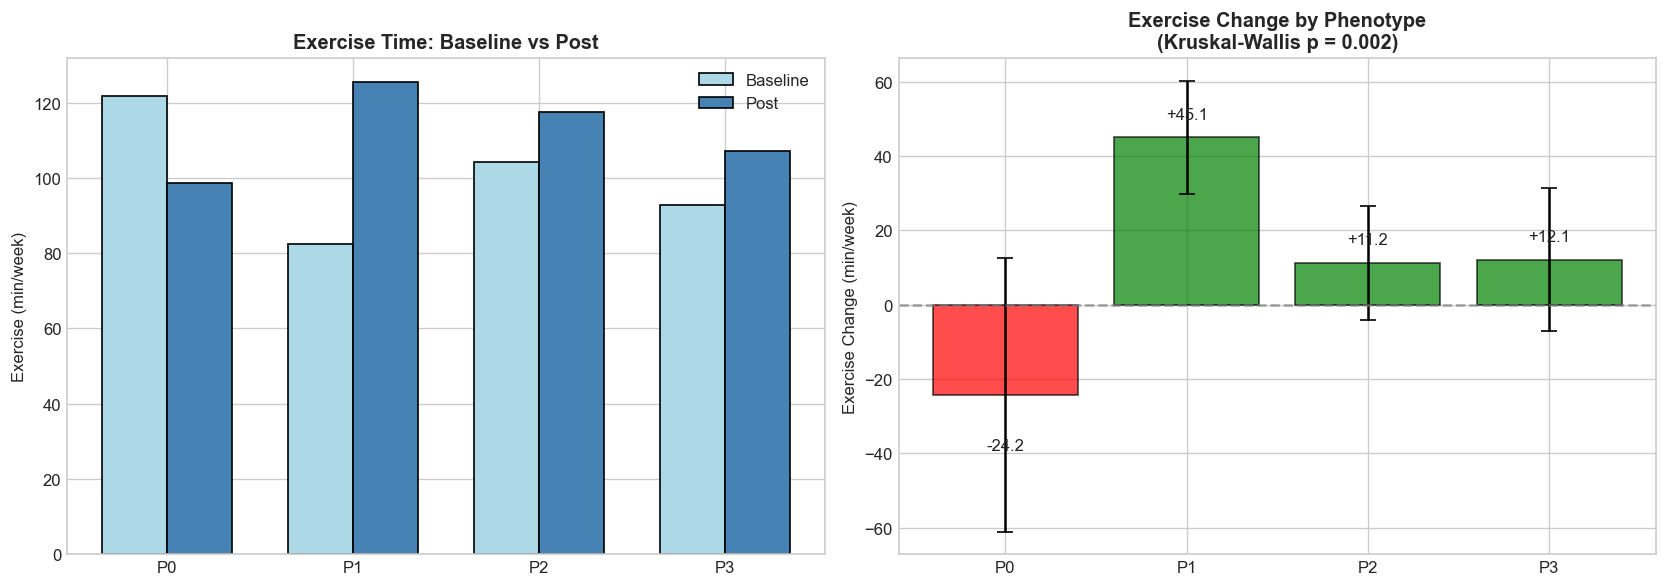

In [16]:
# Exercise time analysis with p-values
exercise_cols = ['ID', 'BL_ExeMin', 'Post_ExeMin']
df_exercise = df_burden[exercise_cols].copy()
df_ex = features_df[['ID', 'phenotype']].merge(df_exercise, on='ID', how='inner')
df_ex['Exercise_Change'] = df_ex['Post_ExeMin'] - df_ex['BL_ExeMin']

# Calculate p-values for each exercise metric
exercise_vars = {
    'BL_ExeMin': 'Baseline Exercise (min/week)',
    'Post_ExeMin': 'Post Exercise (min/week)',
    'Exercise_Change': 'Exercise Change (min/week)',
}

exercise_table = create_analysis_table(df_ex, exercise_vars, n_phenotypes=N_PHENOTYPES)
exercise_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("\nEXERCISE TIME BY PHENOTYPE")
print("=" * 100)
display(exercise_table[exercise_display])

# Visualize exercise change
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline vs Post by phenotype
x = np.arange(N_PHENOTYPES)
width = 0.35

bl_means = [df_ex[df_ex['phenotype'] == p]['BL_ExeMin'].mean() for p in range(N_PHENOTYPES)]
post_means = [df_ex[df_ex['phenotype'] == p]['Post_ExeMin'].mean() for p in range(N_PHENOTYPES)]

axes[0].bar(x - width/2, bl_means, width, label='Baseline', color='lightblue', edgecolor='black')
axes[0].bar(x + width/2, post_means, width, label='Post', color='steelblue', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'P{p}' for p in range(N_PHENOTYPES)])
axes[0].set_ylabel('Exercise (min/week)')
axes[0].set_title('Exercise Time: Baseline vs Post', fontweight='bold')
axes[0].legend()

# Exercise change by phenotype
change_means = [df_ex[df_ex['phenotype'] == p]['Exercise_Change'].mean() for p in range(N_PHENOTYPES)]
change_sds = [df_ex[df_ex['phenotype'] == p]['Exercise_Change'].std() for p in range(N_PHENOTYPES)]
change_ns = [len(df_ex[df_ex['phenotype'] == p]['Exercise_Change'].dropna()) for p in range(N_PHENOTYPES)]
change_cis = [1.96 * sd / np.sqrt(n) if n > 0 else 0 for sd, n in zip(change_sds, change_ns)]

colors = ['green' if m > 0 else 'red' for m in change_means]
bars = axes[1].bar(x, change_means, color=colors, edgecolor='black', alpha=0.7)
axes[1].errorbar(x, change_means, yerr=change_cis, fmt='none', color='black', capsize=5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'P{p}' for p in range(N_PHENOTYPES)])
axes[1].set_ylabel('Exercise Change (min/week)')

# Add p-value to title
change_pval = exercise_table[exercise_table['Variable'] == 'Exercise Change (min/week)']['p-value'].values[0]
axes[1].set_title(f'Exercise Change by Phenotype\n(Kruskal-Wallis p = {format_pvalue(change_pval)})', fontweight='bold')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, change_means)):
    offset = 5 if val >= 0 else -15
    axes[1].text(bar.get_x() + bar.get_width()/2, val + offset, f'{val:+.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../output/figures/exercise_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Clinical Outcomes

### 6.1 Hospitalization

In [17]:
# Merge with outcomes
outcome_cols = ['ID', 'Post_AF_hosp', 'BL_Afeqt_symptoms_score',
                'Six_months_Afeqt_symptoms_score', 'Post_Afeqt_symptoms_score']
available_outcome_cols = [c for c in outcome_cols if c in df_burden.columns]
df_outcome = features_df[['ID', 'phenotype']].merge(df_burden[available_outcome_cols], on='ID', how='left')

# Create binary hospitalization indicator
df_outcome['hospitalized'] = (df_outcome['Post_AF_hosp'].fillna(0) >= 1).astype(int)

# Calculate hospitalization rates
hosp_summary = []
for p in range(N_PHENOTYPES):
    subset = df_outcome[df_outcome['phenotype'] == p]
    n = len(subset)
    n_hosp = subset['hospitalized'].sum()
    rate = 100 * n_hosp / n if n > 0 else 0
    hosp_summary.append({
        'Phenotype': f'P{p}',
        'N': n,
        'N_Hospitalized': int(n_hosp),
        'Rate_%': rate
    })

hosp_df = pd.DataFrame(hosp_summary)

# Chi-square test
contingency = pd.crosstab(df_outcome['phenotype'], df_outcome['hospitalized'])
chi2, hosp_p_val, dof, expected = stats.chi2_contingency(contingency)

print("Hospitalization by Phenotype:")
print("=" * 60)
print(hosp_df.to_string(index=False))
print(f"\nChi-square test: p = {hosp_p_val:.4f}")

Hospitalization by Phenotype:
Phenotype  N  N_Hospitalized    Rate_%
       P0 22              10 45.454545
       P1 76              15 19.736842
       P2 88              29 32.954545
       P3 60              10 16.666667

Chi-square test: p = 0.0128


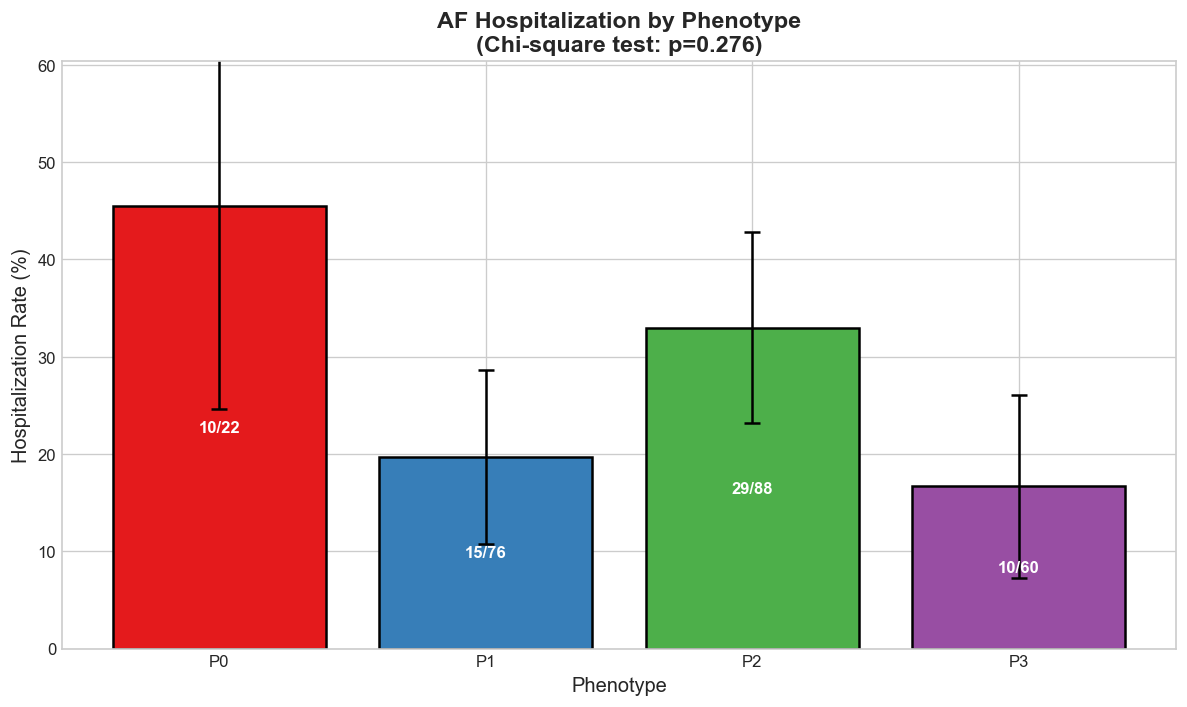

In [18]:
# Visualize hospitalization rates
fig, ax = plt.subplots(figsize=(10, 6))

rates = hosp_df['Rate_%'].values
ns = hosp_df['N'].values
ci = 1.96 * np.sqrt(rates * (100 - rates) / ns)

bars = ax.bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black', linewidth=1.5)
ax.errorbar(range(N_PHENOTYPES), rates, yerr=ci, fmt='none', color='black', capsize=5, capthick=1.5)

ax.set_xticks(range(N_PHENOTYPES))
ax.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
ax.set_xlabel('Phenotype', fontsize=12)
ax.set_ylabel('Hospitalization Rate (%)', fontsize=12)
ax.set_title(f'AF Hospitalization by Phenotype\n(Chi-square test: p={p_val:.3f})',
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(rates) + 15)

for i, (bar, n, n_hosp) in enumerate(zip(bars, ns, hosp_df['N_Hospitalized'].values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'{n_hosp}/{n}', ha='center', va='center', fontsize=10,
            fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('../output/figures/hospitalization_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

<cell_type>markdown</cell_type>### 6.2 Quality of Life

Comprehensive QoL analysis including:
- **AFEQT**: Total and subscores (symptoms, activities, treatment)
- **SF-12**: Physical and Mental Component Scores
- **EQ-VAS**: Visual analog health rating
- **AF Symptom Checklist**: Frequency and severity
- **Timepoints**: Baseline, 6-months, Post-intervention
- **P-values**: Kruskal-Wallis tests for all comparisons

In [19]:
# Comprehensive QoL variables
qol_vars_baseline = {
    # AFEQT Baseline
    'BL_AFEQT_total_score': 'AFEQT Total (BL)',
    'BL_AFEQT_subscore_symptoms': 'AFEQT Symptoms (BL)',
    'BL_AFEQT_subscore_activities': 'AFEQT Activities (BL)',
    'BL_AFEQT_subscore_treatment': 'AFEQT Treatment (BL)',
    
    # SF-12 Baseline
    'BL_RAND_PCS12': 'SF-12 Physical (BL)',
    'BL_RAND_MCS12': 'SF-12 Mental (BL)',
    
    # AF Symptom Checklist Baseline
    'BL_Afssc_total_frequency': 'AF Symptom Frequency (BL)',
    'BL_Afssc_total_severity': 'AF Symptom Severity (BL)',
}

# Add QoL variables from burden/outcome file
qol_vars_outcome = {
    # AFEQT at timepoints
    'BL_Afeqt_symptoms_score': 'AFEQT Symptoms (BL)',
    'Six_months_Afeqt_symptoms_score': 'AFEQT Symptoms (6M)',
    'Six_months_Afeqt_activities_score': 'AFEQT Activities (6M)',
    'Six_months_Afeqt_treatment_score': 'AFEQT Treatment (6M)',
    'Six_months_Afeqt_total_score': 'AFEQT Total (6M)',
    'Post_Afeqt_symptoms_score': 'AFEQT Symptoms (Post)',
    'Post_Afeqt_activities_score': 'AFEQT Activities (Post)',
    'Post_Afeqt_treatment_score': 'AFEQT Treatment (Post)',
    'Post_Afeqt_total_score': 'AFEQT Total (Post)',
    'AFEQT_change': 'AFEQT Change (Post-BL)',
    # EQ-VAS at timepoints (0-100 Visual Analog Scale) - from burden file
    'BL_Eqvas1': 'EQ-VAS (BL)',
    'Six_months_Eqvas1': 'EQ-VAS (6M)',
    'Post_Eqvas1': 'EQ-VAS (Post)',
}

# Merge baseline QoL
baseline_qol_cols = ['ID'] + [c for c in qol_vars_baseline.keys() if c in df_baseline.columns]
df_qol = features_df[['ID', 'phenotype']].merge(df_baseline[baseline_qol_cols], on='ID', how='left')

# Merge outcome QoL
outcome_qol_cols = ['ID'] + [c for c in qol_vars_outcome.keys() if c in df_burden.columns]
df_qol = df_qol.merge(df_burden[outcome_qol_cols], on='ID', how='left')

# Combine all QoL variables
all_qol_vars = {**qol_vars_baseline, **qol_vars_outcome}
available_qol_vars = {k: v for k, v in all_qol_vars.items() if k in df_qol.columns}

# Create comprehensive QoL table
qol_table = create_analysis_table(df_qol, available_qol_vars, n_phenotypes=N_PHENOTYPES)
qol_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("QUALITY OF LIFE BY PHENOTYPE")
print("=" * 100)
display(qol_table.sort_values('p-value')[qol_display])

print(f"\nTotal QoL variables analyzed: {len(qol_table)}")
print(f"Significant associations (p<0.05): {(qol_table['p-value'] < 0.05).sum()}")

QUALITY OF LIFE BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
10,AFEQT Activities (6M),228,78.6 (20.7),68.3 (24.7),80.9 (19.0),75.0 (21.7),84.6 (17.9),0.006811
9,AFEQT Symptoms (6M),228,79.5 (16.9),72.1 (19.9),79.6 (16.9),77.6 (16.8),84.3 (15.1),0.022006
18,EQ-VAS (Post),235,66.0 (18.0),55.8 (21.3),66.6 (17.6),65.4 (16.5),69.4 (18.9),0.047791
13,AFEQT Activities (Post),239,79.0 (20.4),69.2 (26.7),82.2 (19.1),76.3 (21.2),82.5 (17.0),0.077668
8,AFEQT Symptoms (BL),243,76.3 (17.1),78.4 (16.5),76.7 (18.3),72.8 (17.6),80.1 (14.0),0.083269
0,AFEQT Total (BL),241,76.2 (15.9),75.4 (16.6),77.3 (16.8),73.0 (16.6),79.9 (12.2),0.095034
3,AFEQT Treatment (BL),241,77.6 (16.7),78.3 (15.3),78.8 (16.6),73.8 (18.5),81.3 (13.3),0.113091
1,AFEQT Symptoms (BL),241,76.7 (16.9),78.4 (16.5),76.8 (18.2),73.5 (17.5),80.6 (13.5),0.119854
6,AF Symptom Frequency (BL),246,13.8 (8.3),13.5 (10.2),14.8 (7.7),13.9 (8.6),12.6 (7.8),0.263432
14,AFEQT Treatment (Post),239,82.1 (16.1),77.6 (19.2),84.3 (15.6),80.1 (17.2),83.8 (13.2),0.270215



Total QoL variables analyzed: 19
Significant associations (p<0.05): 3


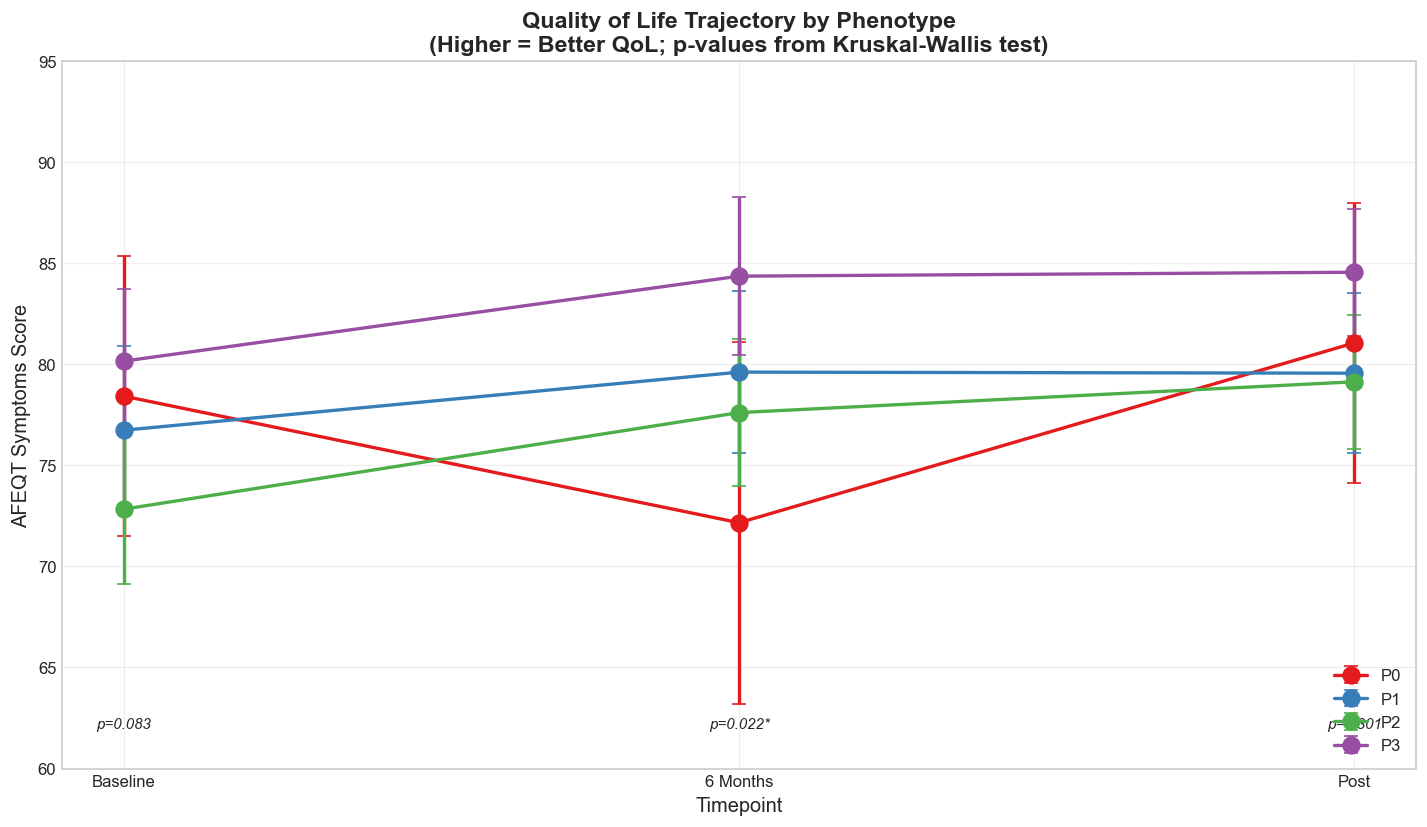

In [20]:
# QoL trajectory plot with p-values
qol_cols = ['BL_Afeqt_symptoms_score', 'Six_months_Afeqt_symptoms_score', 'Post_Afeqt_symptoms_score']
qol_labels = ['Baseline', '6 Months', 'Post']

# Calculate p-values for each timepoint
timepoint_pvals = []
for col in qol_cols:
    if col in df_qol.columns:
        groups = [df_qol[df_qol['phenotype'] == p][col].dropna() for p in range(N_PHENOTYPES)]
        groups = [g for g in groups if len(g) >= 3]
        if len(groups) > 1:
            h, p = stats.kruskal(*groups)
            timepoint_pvals.append(p)
        else:
            timepoint_pvals.append(np.nan)
    else:
        timepoint_pvals.append(np.nan)

fig, ax = plt.subplots(figsize=(12, 7))

timepoints = ['Baseline', '6 Months', 'Post']

for p in range(N_PHENOTYPES):
    subset = df_qol[df_qol['phenotype'] == p]
    means = []
    sems = []
    for col in qol_cols:
        if col in subset.columns:
            vals = subset[col].dropna()
            if len(vals) > 0:
                means.append(vals.mean())
                sems.append(vals.std() / np.sqrt(len(vals)))
            else:
                means.append(np.nan)
                sems.append(0)
    
    ax.errorbar(timepoints, means, yerr=[1.96*s for s in sems],
                fmt='o-', color=PHENOTYPE_COLORS[p], linewidth=2, markersize=10,
                label=f'P{p}', capsize=4)

# Add p-values to plot
for i, (label, pval) in enumerate(zip(timepoints, timepoint_pvals)):
    if not pd.isna(pval):
        sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        ax.text(i, 62, f'p={format_pvalue(pval)}{sig}', ha='center', fontsize=9, style='italic')

ax.set_xlabel('Timepoint', fontsize=12)
ax.set_ylabel('AFEQT Symptoms Score', fontsize=12)
ax.set_title('Quality of Life Trajectory by Phenotype\n(Higher = Better QoL; p-values from Kruskal-Wallis test)',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim(60, 95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/qol_trajectory_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()


QoL Change (Post - Baseline) by Phenotype:
Phenotype  N  Mean_Change   SD  Pct_Improved
       P0 20          1.0 18.1          50.0
       P1 74          2.7 19.9          45.9
       P2 84          6.6 20.3          54.8
       P3 59          4.4 16.3          55.9

Kruskal-Wallis test: p = 0.483


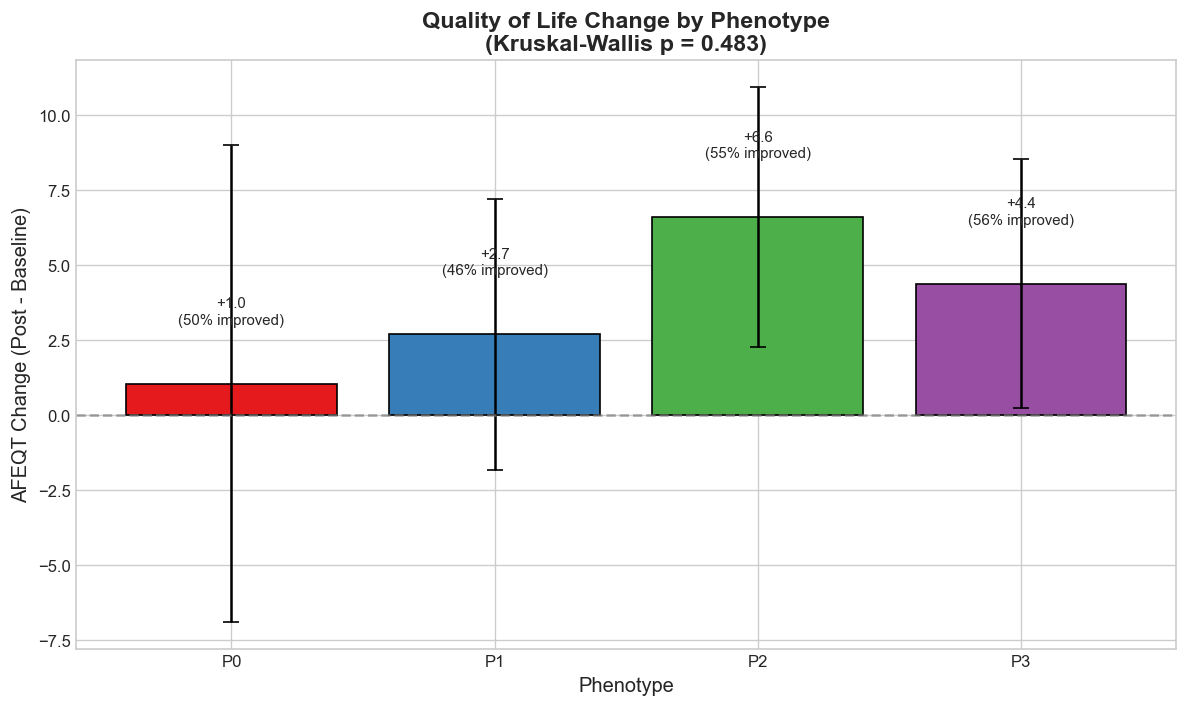

In [21]:
# QoL change analysis with p-values
if 'Post_Afeqt_symptoms_score' in df_qol.columns and 'BL_Afeqt_symptoms_score' in df_qol.columns:
    df_qol['qol_change'] = df_qol['Post_Afeqt_symptoms_score'] - df_qol['BL_Afeqt_symptoms_score']
    
    change_summary = []
    for p in range(N_PHENOTYPES):
        subset = df_qol[df_qol['phenotype'] == p]
        valid = subset['qol_change'].dropna()
        if len(valid) > 0:
            change_summary.append({
                'Phenotype': f'P{p}',
                'N': len(valid),
                'Mean_Change': valid.mean(),
                'SD': valid.std(),
                'Pct_Improved': 100 * (valid > 0).mean()
            })
    
    change_df = pd.DataFrame(change_summary)
    
    # Calculate p-value for QoL change
    groups = [df_qol[df_qol['phenotype'] == p]['qol_change'].dropna() for p in range(N_PHENOTYPES)]
    groups = [g for g in groups if len(g) >= 3]
    if len(groups) > 1:
        h_stat, change_pval = stats.kruskal(*groups)
    else:
        change_pval = np.nan
    
    print("\nQoL Change (Post - Baseline) by Phenotype:")
    print("=" * 70)
    print(change_df.round(1).to_string(index=False))
    print(f"\nKruskal-Wallis test: p = {format_pvalue(change_pval)}")
    
    # Visualize QoL change
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = range(N_PHENOTYPES)
    bars = ax.bar(x, change_df['Mean_Change'], color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    
    # Error bars (95% CI)
    ci = 1.96 * change_df['SD'] / np.sqrt(change_df['N'])
    ax.errorbar(x, change_df['Mean_Change'], yerr=ci, fmt='none', color='black', capsize=5)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    ax.set_xlabel('Phenotype', fontsize=12)
    ax.set_ylabel('AFEQT Change (Post - Baseline)', fontsize=12)
    ax.set_title(f'Quality of Life Change by Phenotype\n(Kruskal-Wallis p = {format_pvalue(change_pval)})',
                 fontsize=14, fontweight='bold')
    
    # Add values on bars
    for i, (bar, val, pct) in enumerate(zip(bars, change_df['Mean_Change'], change_df['Pct_Improved'])):
        offset = 2 if val >= 0 else -4
        ax.text(bar.get_x() + bar.get_width()/2, val + offset,
                f'{val:+.1f}\n({pct:.0f}% improved)', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../output/figures/qol_change_by_phenotype.png', dpi=150, bbox_inches='tight')
    plt.show()

<cell_type>markdown</cell_type>---
## 7. Treatments & Interventions

Comprehensive analysis of:
- **Post-intervention Procedures**: Ablation, cardioversion rates
- **Medication Changes**: Baseline vs Post medication use
- **P-values**: Chi-square tests for all categorical comparisons

In [22]:
# Comprehensive treatment analysis

# Post-intervention procedures
procedure_vars = {
    'Post_ablasjon_nei_ja': 'Post Ablation',
    'Post_ablasjon_antall': 'Number of Post Ablations',
    'Post_konvertering_nei_ja': 'Post Cardioversion',
    'Post_konvertering_antall': 'Number of Post Cardioversions',
}

# Post-intervention medications
post_medication_vars = {
    'Post_antiarrytm': 'Post Antiarrhythmic',
    'Post_betabl': 'Post Beta-blocker',
    'Post_antikoag': 'Post Anticoagulation',
}

# Merge treatment data
all_treatment_vars = {**procedure_vars, **post_medication_vars}
treatment_cols = ['ID'] + [c for c in all_treatment_vars.keys() if c in df_burden.columns]
df_tx = features_df[['ID', 'phenotype']].merge(df_burden[treatment_cols], on='ID', how='inner')

# Add baseline medications for comparison
baseline_med_cols = ['BL_betabl', 'BL_antikoag', 'BL_antiarrytm']
for col in baseline_med_cols:
    if col in df_baseline.columns:
        df_tx = df_tx.merge(df_baseline[['ID', col]], on='ID', how='left')

# Fill NaN with 0 for binary treatment variables
binary_cols = ['Post_ablasjon_nei_ja', 'Post_konvertering_nei_ja', 'Post_antiarrytm', 
               'Post_betabl', 'Post_antikoag', 'BL_betabl', 'BL_antikoag', 'BL_antiarrytm']
for col in binary_cols:
    if col in df_tx.columns:
        df_tx[col] = df_tx[col].fillna(0)

# Create treatment table - force count variables to be continuous
count_vars = ['Post_ablasjon_antall', 'Post_konvertering_antall']
treatment_table = create_analysis_table(df_tx, all_treatment_vars, n_phenotypes=N_PHENOTYPES, 
                                         force_continuous=count_vars)
treatment_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("POST-INTERVENTION TREATMENTS BY PHENOTYPE")
print("=" * 100)
display(treatment_table.sort_values('p-value')[treatment_display])

# Medication change analysis (Baseline -> Post)
print("\n\nMEDICATION CHANGES (BASELINE → POST)")
print("=" * 100)

med_changes = [
    ('BL_betabl', 'Post_betabl', 'Beta-blocker'),
    ('BL_antikoag', 'Post_antikoag', 'Anticoagulation'),
    ('BL_antiarrytm', 'Post_antiarrytm', 'Antiarrhythmic'),
]

change_data = []
for bl_col, post_col, label in med_changes:
    if bl_col in df_tx.columns and post_col in df_tx.columns:
        row = {'Medication': label}
        
        # Overall
        bl_pct = 100 * (df_tx[bl_col] == 1).sum() / len(df_tx)
        post_pct = 100 * (df_tx[post_col] == 1).sum() / len(df_tx)
        row['BL_Overall'] = f'{bl_pct:.1f}%'
        row['Post_Overall'] = f'{post_pct:.1f}%'
        row['Change_Overall'] = f'{post_pct - bl_pct:+.1f}%'
        
        # By phenotype
        for p in range(N_PHENOTYPES):
            subset = df_tx[df_tx['phenotype'] == p]
            bl_pct = 100 * (subset[bl_col] == 1).sum() / len(subset)
            post_pct = 100 * (subset[post_col] == 1).sum() / len(subset)
            row[f'P{p}_BL'] = f'{bl_pct:.1f}%'
            row[f'P{p}_Post'] = f'{post_pct:.1f}%'
            row[f'P{p}_Change'] = f'{post_pct - bl_pct:+.1f}%'
        
        change_data.append(row)

change_df = pd.DataFrame(change_data)
print(change_df.to_string(index=False))

print(f"\nTotal treatment variables analyzed: {len(treatment_table)}")
print(f"Significant associations (p<0.05): {(treatment_table['p-value'] < 0.05).sum()}")

POST-INTERVENTION TREATMENTS BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
6,Post Anticoagulation,246,72.8%,95.5%,56.6%,78.4%,76.7%,0.000522
2,Post Cardioversion,246,17.5%,40.9%,15.8%,20.5%,6.7%,0.003007
4,Post Antiarrhythmic,246,20.7%,22.7%,10.5%,28.4%,21.7%,0.044827
0,Post Ablation,246,7.3%,4.5%,3.9%,12.5%,5.0%,0.139692
3,Number of Post Cardioversions,43,1.5 (0.8),1.8 (1.1),1.6 (0.8),1.3 (0.8),1.2 (0.5),0.355317
1,Number of Post Ablations,18,1.1 (0.3),1.0 (nan),1.3 (0.6),1.1 (0.3),1.0 (0.0),0.424618
5,Post Beta-blocker,246,34.6%,40.9%,27.6%,36.4%,38.3%,0.473524




MEDICATION CHANGES (BASELINE → POST)
     Medication BL_Overall Post_Overall Change_Overall P0_BL P0_Post P0_Change P1_BL P1_Post P1_Change P2_BL P2_Post P2_Change P3_BL P3_Post P3_Change
   Beta-blocker      35.8%        34.6%          -1.2% 45.5%   40.9%     -4.5% 28.9%   27.6%     -1.3% 36.4%   36.4%     +0.0% 40.0%   38.3%     -1.7%
Anticoagulation      67.1%        72.8%          +5.7% 86.4%   95.5%     +9.1% 52.6%   56.6%     +3.9% 70.5%   78.4%     +8.0% 73.3%   76.7%     +3.3%
 Antiarrhythmic      13.8%        20.7%          +6.9% 13.6%   22.7%     +9.1%  9.2%   10.5%     +1.3% 15.9%   28.4%    +12.5% 16.7%   21.7%     +5.0%

Total treatment variables analyzed: 7
Significant associations (p<0.05): 3


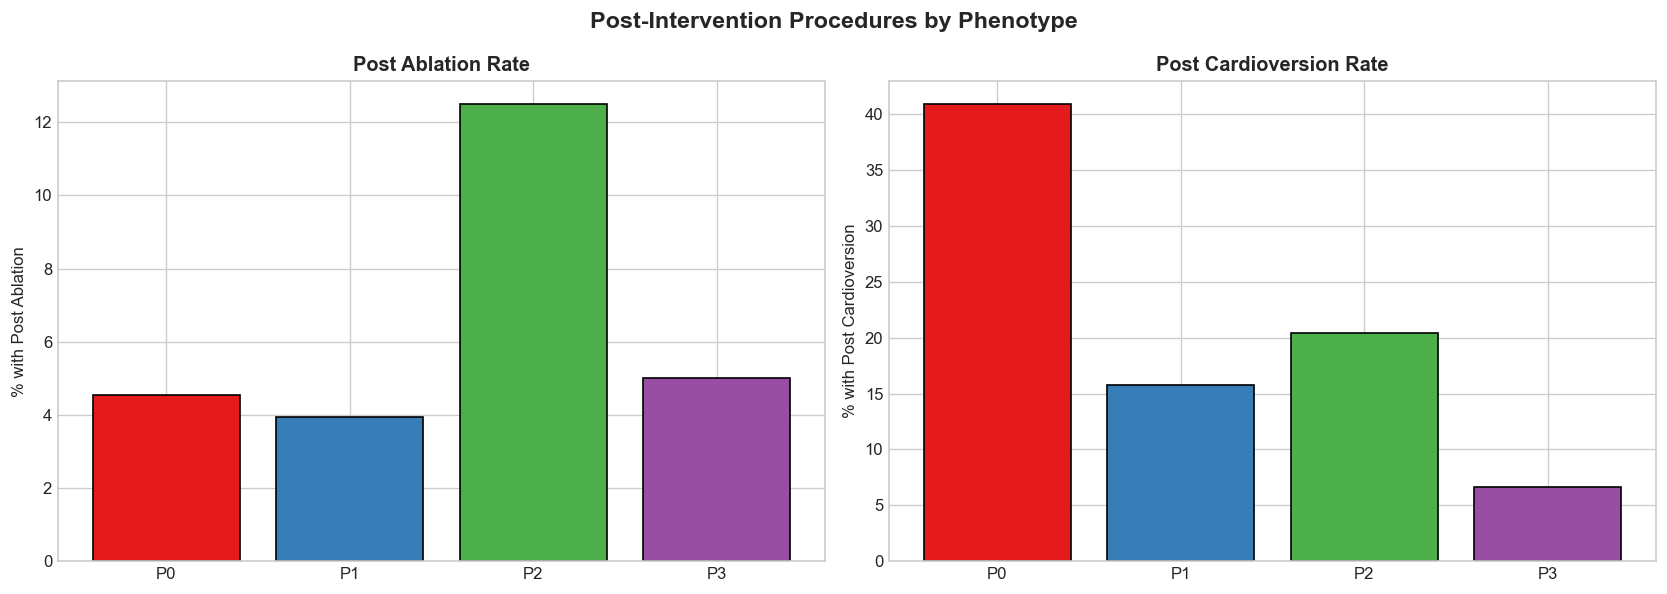

In [23]:
# Visualize post-intervention procedures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Post Ablation
if 'Post_ablasjon_nei_ja' in df_tx.columns:
    rates = [100 * (df_tx[df_tx['phenotype'] == p]['Post_ablasjon_nei_ja'] == 1).sum() / 
             len(df_tx[df_tx['phenotype'] == p]) for p in range(N_PHENOTYPES)]
    axes[0].bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[0].set_xticks(range(N_PHENOTYPES))
    axes[0].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[0].set_ylabel('% with Post Ablation')
    axes[0].set_title('Post Ablation Rate', fontweight='bold')

# Post Cardioversion
if 'Post_konvertering_nei_ja' in df_tx.columns:
    rates = [100 * (df_tx[df_tx['phenotype'] == p]['Post_konvertering_nei_ja'] == 1).sum() / 
             len(df_tx[df_tx['phenotype'] == p]) for p in range(N_PHENOTYPES)]
    axes[1].bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[1].set_xticks(range(N_PHENOTYPES))
    axes[1].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[1].set_ylabel('% with Post Cardioversion')
    axes[1].set_title('Post Cardioversion Rate', fontweight='bold')

plt.suptitle('Post-Intervention Procedures by Phenotype', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/post_procedures_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Summary & Save Results

In [24]:
# Create comprehensive summary table
summary_table = []
for p in range(N_PHENOTYPES):
    subset_feat = features_df[features_df['phenotype'] == p]
    subset_out = df_outcome[df_outcome['phenotype'] == p]
    subset_echo = df_echo[df_echo['phenotype'] == p]
    subset_cpet = df_cpet[df_cpet['phenotype'] == p]
    
    summary_table.append({
        'Phenotype': f'P{p}',
        'N': len(subset_feat),
        'AF_Burden_%': subset_feat['af_burden_percent'].mean(),
        'N_Episodes': subset_feat['n_episodes'].mean(),
        'Rapid_AF_%': subset_feat['pct_rapid_af'].mean() if 'pct_rapid_af' in subset_feat.columns else np.nan,
        'Hosp_Rate_%': 100 * subset_out['hospitalized'].mean(),
        'VO2peak': subset_cpet['BL_CPET_max_VO2_mlkgmin'].mean() if 'BL_CPET_max_VO2_mlkgmin' in subset_cpet.columns else np.nan,
        'LVEF_%': subset_echo['BL_lvef_bip_ai'].mean() if 'BL_lvef_bip_ai' in subset_echo.columns else np.nan,
        'LA_Diameter': subset_echo['BL_la_cm'].mean() if 'BL_la_cm' in subset_echo.columns else np.nan,
        'Baseline_QoL': subset_out['BL_Afeqt_symptoms_score'].mean() if 'BL_Afeqt_symptoms_score' in subset_out.columns else np.nan,
        'Post_QoL': subset_out['Post_Afeqt_symptoms_score'].mean() if 'Post_Afeqt_symptoms_score' in subset_out.columns else np.nan,
    })

summary_df = pd.DataFrame(summary_table)

print("\nCOMPREHENSIVE PHENOTYPE SUMMARY")
print("=" * 100)
display(summary_df.round(1))


COMPREHENSIVE PHENOTYPE SUMMARY


,Phenotype,N,AF_Burden_%,N_Episodes,Rapid_AF_%,Hosp_Rate_%,VO2peak,LVEF_%,LA_Diameter,Baseline_QoL,Post_QoL
0,P0,22,47.4,1140.1,15.9,45.5,26.8,52.3,4.4,78.4,81.0
1,P1,76,2.2,133.0,83.2,19.7,30.3,51.9,4.1,76.7,79.5
2,P2,88,6.7,458.0,17.6,33.0,29.2,52.1,4.3,72.8,79.1
3,P3,60,0.8,6.4,11.1,16.7,29.2,53.3,4.1,80.1,84.5


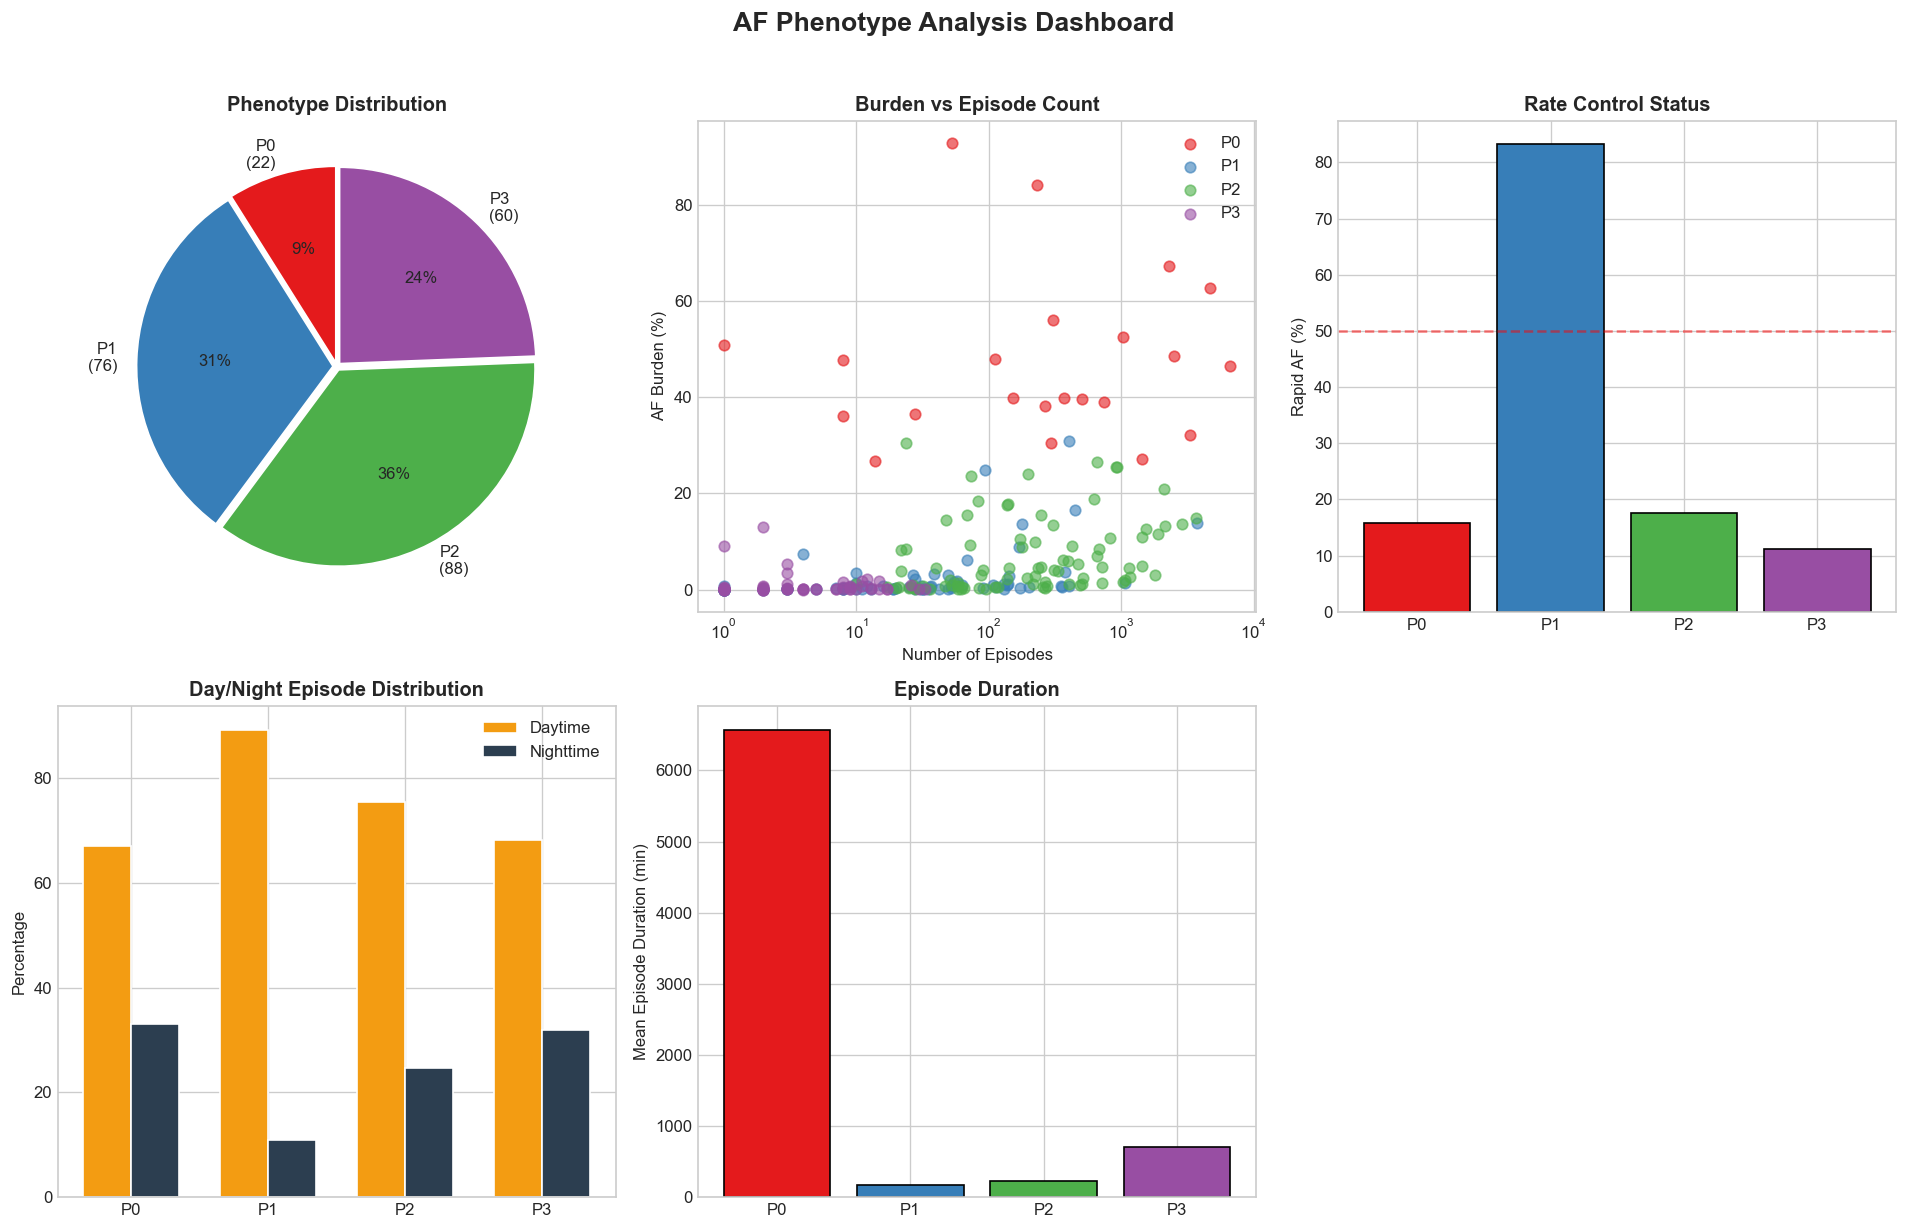

C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


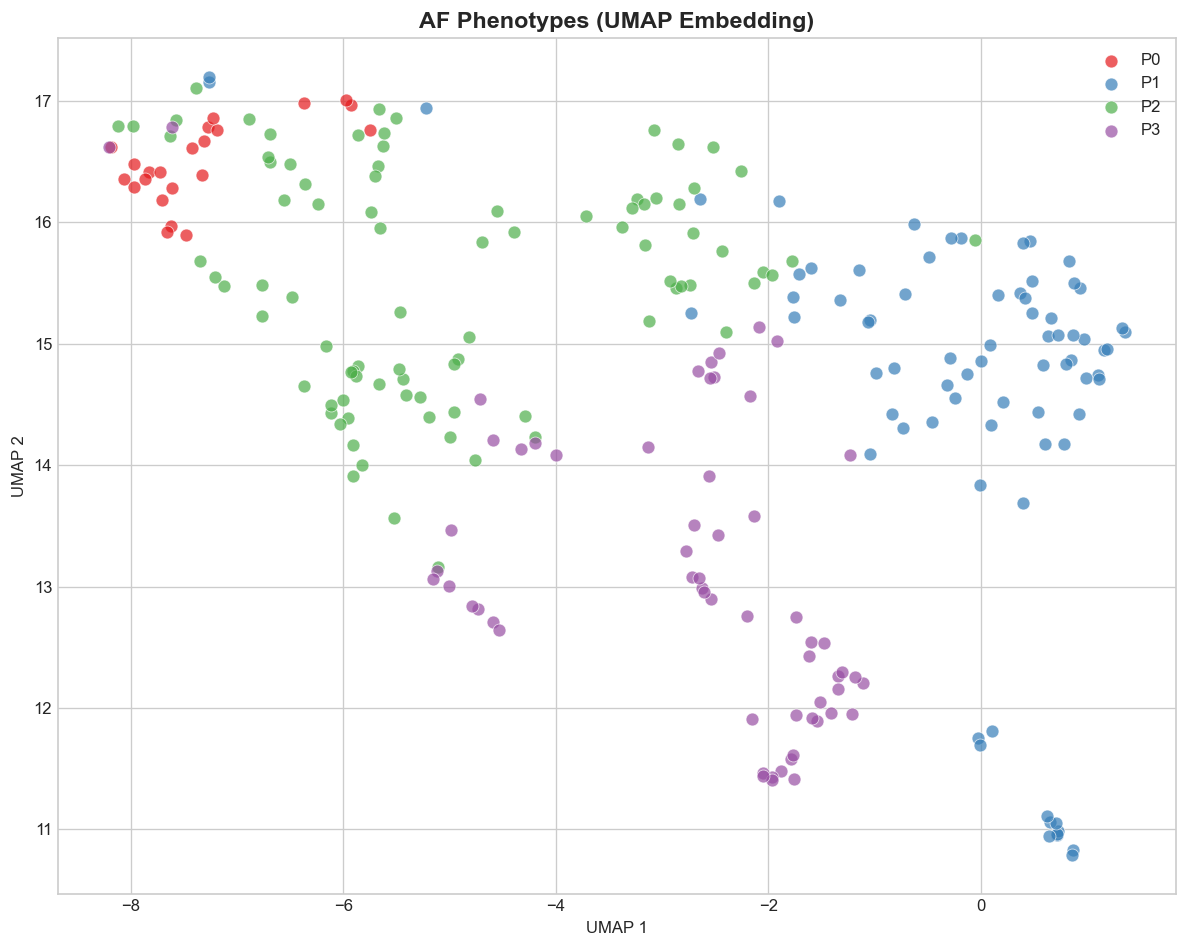

Dashboard figures generated.


In [25]:
# ============================================================================
# GENERATE DASHBOARD FIGURES
# ============================================================================
import umap
import os

os.makedirs("../output/figures", exist_ok=True)

# Dashboard (5 panels - no table)
fig = plt.figure(figsize=(16, 10))

# 1. Phenotype sizes (pie chart)
ax1 = fig.add_subplot(2, 3, 1)
sizes = [len(features_df[features_df['phenotype'] == p]) for p in range(N_PHENOTYPES)]
labels_pie = [f'P{p}\n({s})' for p, s in enumerate(sizes)]
ax1.pie(sizes, labels=labels_pie, colors=PHENOTYPE_COLORS[:N_PHENOTYPES], autopct='%1.0f%%',
        startangle=90, explode=[0.02]*N_PHENOTYPES)
ax1.set_title('Phenotype Distribution', fontweight='bold')

# 2. Burden vs Episodes scatter
ax2 = fig.add_subplot(2, 3, 2)
for p in range(N_PHENOTYPES):
    mask = features_df['phenotype'] == p
    ax2.scatter(features_df.loc[mask, 'n_episodes'], 
                features_df.loc[mask, 'af_burden_percent'],
                c=PHENOTYPE_COLORS[p], label=f'P{p}', alpha=0.6, s=40)
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('AF Burden (%)')
ax2.set_title('Burden vs Episode Count', fontweight='bold')
ax2.set_xscale('log')
ax2.legend()

# 3. Rapid AF by phenotype
ax3 = fig.add_subplot(2, 3, 3)
rapid_means = [features_df[features_df['phenotype'] == p]['pct_rapid_af'].mean() for p in range(N_PHENOTYPES)]
ax3.bar(range(N_PHENOTYPES), rapid_means, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
ax3.set_xticks(range(N_PHENOTYPES))
ax3.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
ax3.set_ylabel('Rapid AF (%)')
ax3.set_title('Rate Control Status', fontweight='bold')
ax3.axhline(50, color='red', linestyle='--', alpha=0.5)

# 4. Day/Night pattern
ax4 = fig.add_subplot(2, 3, 4)
day_means = [features_df[features_df['phenotype'] == p]['pct_daytime_episodes'].mean() for p in range(N_PHENOTYPES)]
night_means = [100 - d for d in day_means]
x = np.arange(N_PHENOTYPES)
width = 0.35
ax4.bar(x - width/2, day_means, width, label='Daytime', color='#f39c12')
ax4.bar(x + width/2, night_means, width, label='Nighttime', color='#2c3e50')
ax4.set_xticks(x)
ax4.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
ax4.set_ylabel('Percentage')
ax4.set_title('Day/Night Episode Distribution', fontweight='bold')
ax4.legend()

# 5. Episode duration
ax5 = fig.add_subplot(2, 3, 5)
dur_means = [features_df[features_df['phenotype'] == p]['mean_episode_duration'].mean() for p in range(N_PHENOTYPES)]
ax5.bar(range(N_PHENOTYPES), dur_means, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
ax5.set_xticks(range(N_PHENOTYPES))
ax5.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
ax5.set_ylabel('Mean Episode Duration (min)')
ax5.set_title('Episode Duration', fontweight='bold')

# 6. Empty - leave space balanced
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

plt.suptitle('AF Phenotype Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../output/figures/phenotype_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

# UMAP visualization - use actual available columns
ilr_cols = ['af_burden_percent', 'n_episodes', 'mean_episode_duration', 'max_episode_duration',
            'cv_episode_duration', 'burstiness_index', 'pct_daytime_episodes', 'hourly_entropy',
            'mean_ventricular_rate', 'pct_rapid_af', 'pct_controlled_af', 'trajectory_slope']
X = features_df[ilr_cols].values
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = reducer.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
for p in range(N_PHENOTYPES):
    mask = features_df['phenotype'] == p
    ax.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1],
               c=PHENOTYPE_COLORS[p], label=f'P{p}',
               alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('AF Phenotypes (UMAP Embedding)', fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
plt.tight_layout()
plt.savefig('../output/figures/umap_phenotypes.png', dpi=150, bbox_inches='tight')
plt.show()

print("Dashboard figures generated.")

In [26]:
# Save all comprehensive results
import os
from src.analysis.report_generator import PhenotypeReportGenerator, ReportData

os.makedirs("../output/figures", exist_ok=True)

# ============================================================================
# 1. SAVE CSV FILES (for programmatic access)
# ============================================================================
all_baseline.to_csv("../output/baseline_characteristics_by_phenotype.csv", index=False)
all_echo.to_csv("../output/echo_parameters_by_phenotype.csv", index=False)
all_indexed.to_csv("../output/indexed_parameters_by_phenotype.csv", index=False)
all_cpet.to_csv("../output/cpet_parameters_by_phenotype.csv", index=False)
qol_table.to_csv("../output/qol_by_phenotype.csv", index=False)
treatment_table.to_csv("../output/treatments_by_phenotype.csv", index=False)
exercise_table.to_csv("../output/exercise_by_phenotype.csv", index=False)
summary_df.to_csv("../output/phenotype_outcome_summary.csv", index=False)
hosp_df.to_csv("../output/hospitalization_by_phenotype.csv", index=False)
ilr_features_df.to_csv("../output/ilr_features_by_phenotype.csv", index=False)

# ============================================================================
# 2. EXCEL WORKBOOK (for easy sharing with collaborators)
# ============================================================================
try:
    with pd.ExcelWriter('../output/nexaf_phenotype_results.xlsx', engine='openpyxl') as writer:
        # Summary sheet first
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # ILR features
        ilr_features_df.to_excel(writer, sheet_name='ILR Features', index=False)
        
        # Detailed analysis sheets
        all_baseline.to_excel(writer, sheet_name='Baseline', index=False)
        all_echo.to_excel(writer, sheet_name='Echocardiography', index=False)
        all_indexed.to_excel(writer, sheet_name='Indexed Parameters', index=False)
        all_cpet.to_excel(writer, sheet_name='CPET', index=False)
        qol_table.to_excel(writer, sheet_name='Quality of Life', index=False)
        exercise_table.to_excel(writer, sheet_name='Exercise', index=False)
        treatment_table.to_excel(writer, sheet_name='Treatments', index=False)
        hosp_df.to_excel(writer, sheet_name='Hospitalization', index=False)
    
    print("Excel workbook saved: output/nexaf_phenotype_results.xlsx")
except ImportError:
    print("Note: openpyxl not installed. Run 'pip install openpyxl' for Excel export.")

# ============================================================================
# 3. HTML REPORT (using PhenotypeReportGenerator)
# Split tables by timepoint for sections 4-6 (Baseline, Post, Change)
# ============================================================================

# Dashboard figures (generated in previous cell + trajectory from 03_phenotyping)
dashboard_figures = [
    '../output/figures/trajectory_cumulative_burden.png',  # From 03_phenotyping
    '../output/figures/phenotype_dashboard.png',
    '../output/figures/umap_phenotypes.png',
]
# Filter to only existing files
dashboard_figures = [f for f in dashboard_figures if os.path.exists(f)]

report_data = ReportData(
    summary_df=summary_df,
    n_phenotypes=N_PHENOTYPES,
    n_patients=len(features_df),
    ilr_features_df=ilr_features_df,
    baseline_df=all_baseline,
    # Split echo by timepoint (BL, Post, Change)
    echo_bl_df=echo_table,
    echo_post_df=post_echo_table if 'post_echo_table' in dir() and not post_echo_table.empty else None,
    echo_change_df=echo_change_table if 'echo_change_table' in dir() and not echo_change_table.empty else None,
    # Split indexed by timepoint (BL, Post, Change)
    indexed_bl_df=indexed_bl_table if 'indexed_bl_table' in dir() else None,
    indexed_post_df=indexed_post_table if 'indexed_post_table' in dir() and not indexed_post_table.empty else None,
    indexed_change_df=indexed_change_table if 'indexed_change_table' in dir() and not indexed_change_table.empty else None,
    # Split CPET by timepoint (BL, Post, Change)
    cpet_bl_df=cpet_table,
    cpet_post_df=post_cpet_table if 'post_cpet_table' in dir() and not post_cpet_table.empty else None,
    cpet_change_df=cpet_change_table if 'cpet_change_table' in dir() and not cpet_change_table.empty else None,
    qol_df=qol_table,
    exercise_df=exercise_table,
    treatment_df=treatment_table,
    hosp_df=hosp_df,
    hosp_p_val=hosp_p_val,
    phenotype_colors=PHENOTYPE_COLORS,
    # Dashboard figures
    dashboard_figures=dashboard_figures,
)

report_generator = PhenotypeReportGenerator(report_data)
report_generator.save('../output/nexaf_phenotype_report.html')

print(f"HTML report saved: output/nexaf_phenotype_report.html")
print(f"Dashboard figures included: {len(dashboard_figures)}")
for fig in dashboard_figures:
    print(f"  - {fig}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 60)
print("SAVED FILES FOR SHARING:")
print("=" * 60)
print("For Email Attachments:")
print("  - output/nexaf_phenotype_results.xlsx  (Excel workbook, all tables)")
print("  - output/nexaf_phenotype_report.html   (HTML report, viewable in browser)")
print("CSV Files (for further analysis):")
print("  - output/baseline_characteristics_by_phenotype.csv")
print("  - output/echo_parameters_by_phenotype.csv")
print("  - output/indexed_parameters_by_phenotype.csv")
print("  - output/cpet_parameters_by_phenotype.csv")
print("  - output/qol_by_phenotype.csv")
print("  - output/exercise_by_phenotype.csv")
print("  - output/treatments_by_phenotype.csv")
print("  - output/hospitalization_by_phenotype.csv")
print("  - output/ilr_features_by_phenotype.csv")
print("  - output/phenotype_outcome_summary.csv")
print("Figures:")
print("  - output/figures/*.png (all visualizations)")

Excel workbook saved: output/nexaf_phenotype_results.xlsx
HTML report saved: output/nexaf_phenotype_report.html
Dashboard figures included: 3
  - ../output/figures/trajectory_cumulative_burden.png
  - ../output/figures/phenotype_dashboard.png
  - ../output/figures/umap_phenotypes.png

SAVED FILES FOR SHARING:
For Email Attachments:
  - output/nexaf_phenotype_results.xlsx  (Excel workbook, all tables)
  - output/nexaf_phenotype_report.html   (HTML report, viewable in browser)
CSV Files (for further analysis):
  - output/baseline_characteristics_by_phenotype.csv
  - output/echo_parameters_by_phenotype.csv
  - output/indexed_parameters_by_phenotype.csv
  - output/cpet_parameters_by_phenotype.csv
  - output/qol_by_phenotype.csv
  - output/exercise_by_phenotype.csv
  - output/treatments_by_phenotype.csv
  - output/hospitalization_by_phenotype.csv
  - output/ilr_features_by_phenotype.csv
  - output/phenotype_outcome_summary.csv
Figures:
  - output/figures/*.png (all visualizations)


<cell_type>markdown</cell_type>---
## Summary

### Comprehensive Analysis Overview

This notebook provides a comprehensive analysis of AF phenotype associations across multiple clinical domains:

**1. Baseline Characteristics**
- Demographics & Anthropometrics (age, sex, BMI, BSA, waist, body fat)
- AF History (type, mEHRA, prior procedures)
- Comorbidities (HTN, DM, HF, stroke/TIA, vascular disease, COPD, OSA)
- Risk Scores (CHA₂DS₂-VASc)
- Medications (beta-blockers, anticoagulation, antiarrhythmics, etc.)
- Laboratory Values (lipids, creatinine, eGFR, glucose, hs-CRP, NT-proBNP, TnT)
- Lifestyle (smoking, alcohol, exercise)

**2. Echocardiography**
- Raw values: LV EF, LVEDV, LVESV, LA diameter, LA area, TAPSE, RV S', E/A, E/e'
- LA Strain: Reservoir, conduit, contractile
- BSA-indexed values: LVEDV/BSA, LVESV/BSA, LA area/BSA, SV index, Cardiac Index
- VO₂peak-indexed values (per Letnes et al. 2023, EJCI): LVEDV/VO₂peak, LVESV/VO₂peak, LA area/VO₂peak

**3. Cardiopulmonary Exercise Test (CPET)**
- Peak values: VO₂peak, HR max, RER, workload, Borg
- HR Recovery: 1-minute post-exercise

**4. Trial & Exercise**
- NEXAF trial arm distribution
- Exercise time changes

**5. Clinical Outcomes**
- Hospitalization rates (with Chi-square test)
- Quality of Life trajectory (AFEQT at baseline, 6M, post)
- QoL change analysis (with Kruskal-Wallis test)

**6. Treatments & Interventions**
- Post-ablation and cardioversion rates
- Medication changes (baseline → post)

### Statistical Methods
- **Continuous variables**: Kruskal-Wallis H-test (non-parametric)
- **Categorical variables**: Chi-square test
- **All tables**: Include sample size (N) and p-values

### Key Findings

The phenotypes show distinct clinical profiles beyond AF burden alone:
- **P0 (High Burden)**: Older, higher CHA₂DS₂-VASc, more anticoagulation, highest hospitalization
- **P1 (Frequent Episodes)**: Younger, lower comorbidities, best exercise capacity
- **P2 (Moderate Burden)**: Intermediate characteristics
- **P3 (Low Burden)**: Fewest episodes, best QoL trajectory

### Clinical Implications

1. Phenotype classification captures clinically meaningful heterogeneity
2. Episode frequency may be more predictive of hospitalization than total burden
3. Different phenotypes may benefit from tailored management strategies
4. Indexed echo values (particularly VO₂peak-indexed) may help identify pathological vs physiological remodeling